### Постановка задачи

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов.  
Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.  
Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  
Задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание данных

#### Таблица contract

- customerID — ID абонента;  
- BeginDate — дата начала действия договора;  
- EndDate — дата окончания действия договора;  
- Type — тип оплаты: раз в год-два или ежемесячно;  
- PaperlessBilling — электронный расчётный лист;  
- PaymentMethod — тип платежа;  
- MonthlyCharges — расходы за месяц;  
- TotalCharges — общие расходы абонента.

#### Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

#### Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

#### Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

### Настройка окружения

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns

import shap

import torch
import torch.nn as nn

from catboost import CatBoostClassifier
from phik import report

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sqlalchemy import create_engine

from torch.utils.data import DataLoader, TensorDataset
from torch import optim


In [2]:
# Константы
rs = 111124
path_to_db = 'ds-plus-final.db'

### Загрузка данных

In [3]:
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [4]:
contracts_df = pd.read_sql_table("contract", engine)
personal_df = pd.read_sql_table("personal", engine)
internet_df = pd.read_sql_table("internet", engine)
phone_df = pd.read_sql_table("phone", engine)

In [5]:
def data_summary(df):
    """
    Функция для первичного анализа данных датафрейма.
    """
    
    # Общая информация о данных
    print("Общая информация о данных:")
    print(df.info())
    print("\n")

    # Размерность данных
    print(f"Размерность данных: {df.shape[0]} строк, {df.shape[1]} столбцов\n")

    # Первые 5 строк данных
    print("Первые 5 строк данных:")
    display(df.head())
    print("\n")

    # Статистическое описание числовых данных
    print("Статистическое описание данных:")
    print(df.describe().T)
    print("\n")

    # Таблица с пропущенными и уникальными значениями
    missing_data = pd.DataFrame({
        'Пропущенные значения': df.isnull().sum(),
        'Доля пропущенных (%)': (df.isnull().mean() * 100).round(2),
        'Уникальные значения': df.nunique()
    })
    print("Информация по пропущенным и уникальным значениям:")
    display(missing_data)
    print("\n")

In [6]:
data_summary(contracts_df)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None


Размерность данных: 7043 строк, 8 столбцов

Первые 5 строк данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5




Статистическое описание данных:
                 count unique               top  freq
customerID        7043   7043        7590-VHVEG     1
BeginDate         7043     77        2014-02-01   366
EndDate           7043     67                No  5942
Type              7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
MonthlyCharges    7043   1585             20.05    61
TotalCharges      7043   6658                      11


Информация по пропущенным и уникальным значениям:


,Пропущенные значения,Доля пропущенных (%),Уникальные значения
customerID,0,0.0,7043
BeginDate,0,0.0,77
EndDate,0,0.0,67
Type,0,0.0,3
PaperlessBilling,0,0.0,2
PaymentMethod,0,0.0,4
MonthlyCharges,0,0.0,1585
TotalCharges,0,0.0,6658


In [7]:
contracts_df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
contracts_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [8]:
data_summary(personal_df)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


Размерность данных: 7043 строк, 5 столбцов

Первые 5 строк данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




Статистическое описание данных:
              count unique         top  freq
customerID     7043   7043  7590-VHVEG     1
gender         7043      2        Male  3555
SeniorCitizen  7043      2           0  5901
Partner        7043      2          No  3641
Dependents     7043      2          No  4933


Информация по пропущенным и уникальным значениям:


,Пропущенные значения,Доля пропущенных (%),Уникальные значения
customerID,0,0.0,7043
gender,0,0.0,2
SeniorCitizen,0,0.0,2
Partner,0,0.0,2
Dependents,0,0.0,2


In [9]:
personal_df.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
personal_df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [10]:
data_summary(internet_df)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Размерность данных: 5517 строк, 8 столбцов

Первые 5 строк данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




Статистическое описание данных:
                 count unique          top  freq
customerID        5517   5517   7590-VHVEG     1
InternetService   5517      2  Fiber optic  3096
OnlineSecurity    5517      2           No  3498
OnlineBackup      5517      2           No  3088
DeviceProtection  5517      2           No  3095
TechSupport       5517      2           No  3473
StreamingTV       5517      2           No  2810
StreamingMovies   5517      2           No  2785


Информация по пропущенным и уникальным значениям:


,Пропущенные значения,Доля пропущенных (%),Уникальные значения
customerID,0,0.0,5517
InternetService,0,0.0,2
OnlineSecurity,0,0.0,2
OnlineBackup,0,0.0,2
DeviceProtection,0,0.0,2
TechSupport,0,0.0,2
StreamingTV,0,0.0,2
StreamingMovies,0,0.0,2


In [11]:
internet_df.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
internet_df.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [12]:
data_summary(phone_df)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Размерность данных: 6361 строк, 2 столбцов

Первые 5 строк данных:


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




Статистическое описание данных:
              count unique         top  freq
CustomerId     6361   6361  5575-GNVDE     1
MultipleLines  6361      2          No  3390


Информация по пропущенным и уникальным значениям:


,Пропущенные значения,Доля пропущенных (%),Уникальные значения
CustomerId,0,0.0,6361
MultipleLines,0,0.0,2


In [13]:
phone_df.columns = ['customer_id', 'multiple_lines']
phone_df.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

### EDA

#### Функции для EDA

In [14]:
def num_descr(df, column, bins):
    
    x=df[column]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16,8))

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=bins, kde=True, ax=ax_hist)
    
    ax_box.set_title(f'Распределение по {column}')
    ax_box.set(yticks=[])
    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

    print('Описание столбца', column)
    print(df[column].describe())
    plt.show()

In [15]:
def cat_descr(df, column):
    print('=====================================')
    print(f'Распределение по {column}')
    print('=====================================')
    display(df[column].unique())
    
    plt.subplot(1, 2, 1)
    value_counts_sorted = df[column].value_counts().sort_values()
    value_counts_sorted.plot(kind='bar', figsize=(12,6), grid=True);
    plt.title(f'Разделение по {column}')
    plt.ylabel('Количество');
    
    for i in range(len(value_counts_sorted)):
        plt.text(i,
                 value_counts_sorted.iloc[i],  # Используем iloc для доступа к элементам по позиции
                 value_counts_sorted.iloc[i], ha='center')
            
    plt.subplot(1,2, 2)
    df[column].value_counts().plot(y='count', kind='pie', autopct="%1.1f%%")
    plt.title(f'Доля по {column}')
    plt.ylabel('')
    
    plt.show()


In [16]:
def data_descr(df, column):
    
    year_counts = df[column].dt.year.value_counts().sort_index()
    month_counts = df[column].dt.month.value_counts().sort_index()

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    sns.barplot(x=year_counts.index, y=year_counts.values, hue=year_counts.index, palette='Blues_d', legend=False)
    plt.title('Частота по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество записей')

    plt.subplot(1, 2, 2)
    sns.barplot(x=month_counts.index, y=month_counts.values, hue=month_counts.index, palette='Greens_d', legend=False)
    plt.title('Частота по месяцам')
    plt.xlabel('Месяц')
    plt.ylabel('Количество записей')
    plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 
                                    'Июль', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])

    plt.show()

In [17]:
def get_col_type(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    print('Числовые столбцы:', numeric_columns)
    print('Категориальные столбцы:', categorical_columns)

    return numeric_columns, categorical_columns

#### contracts_df

In [18]:
contracts_df['begin_date'] = pd.to_datetime(contracts_df['begin_date'], format='%Y-%m-%d')
contracts_df['end_date'] = pd.to_datetime(contracts_df['end_date'], format='%Y-%m-%d', errors='coerce')

print(contracts_df['end_date'].isna().sum(), 'значений \'no\' было заменено на NaT')

5942 значений 'no' было заменено на NaT


У нас было 1101 с датой окончания договора в исходных данных, они остались, остальные значения стали NaT.

In [19]:
contracts_df['monthly_charges'] = pd.to_numeric(contracts_df['monthly_charges'])
contracts_df['total_charges'] = pd.to_numeric(contracts_df['total_charges'], errors='coerce')

In [20]:
contracts_df.describe().T

,count,mean,min,25%,50%,75%,max,std
begin_date,7043,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
end_date,1101,2018-03-12 18:21:15.204359680,2014-06-01 00:00:00,2017-05-01 00:00:00,2018-06-01 00:00:00,2019-04-01 00:00:00,2020-01-01 00:00:00,NaN
monthly_charges,7043.0,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
total_charges,7032.0,2118.621822,19.05,439.745,1345.275,3239.3175,9221.38,2112.736199


In [21]:
num_cols_contracts, cat_cols_contracts = get_col_type(contracts_df)

Числовые столбцы: ['monthly_charges', 'total_charges']
Категориальные столбцы: ['customer_id', 'type', 'paperless_billing', 'payment_method']


In [22]:
cat_cols_contracts.remove('customer_id')

##### Числовые признаки

Описание столбца monthly_charges
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


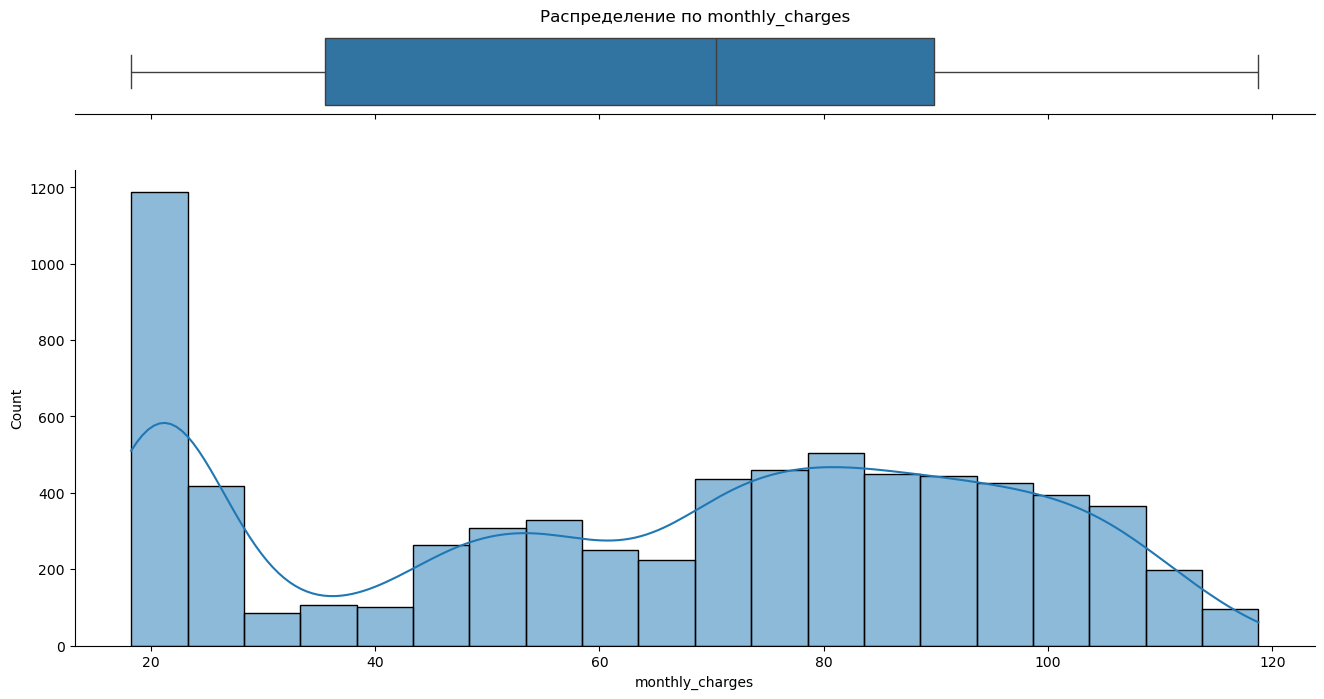

Описание столбца total_charges
count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64


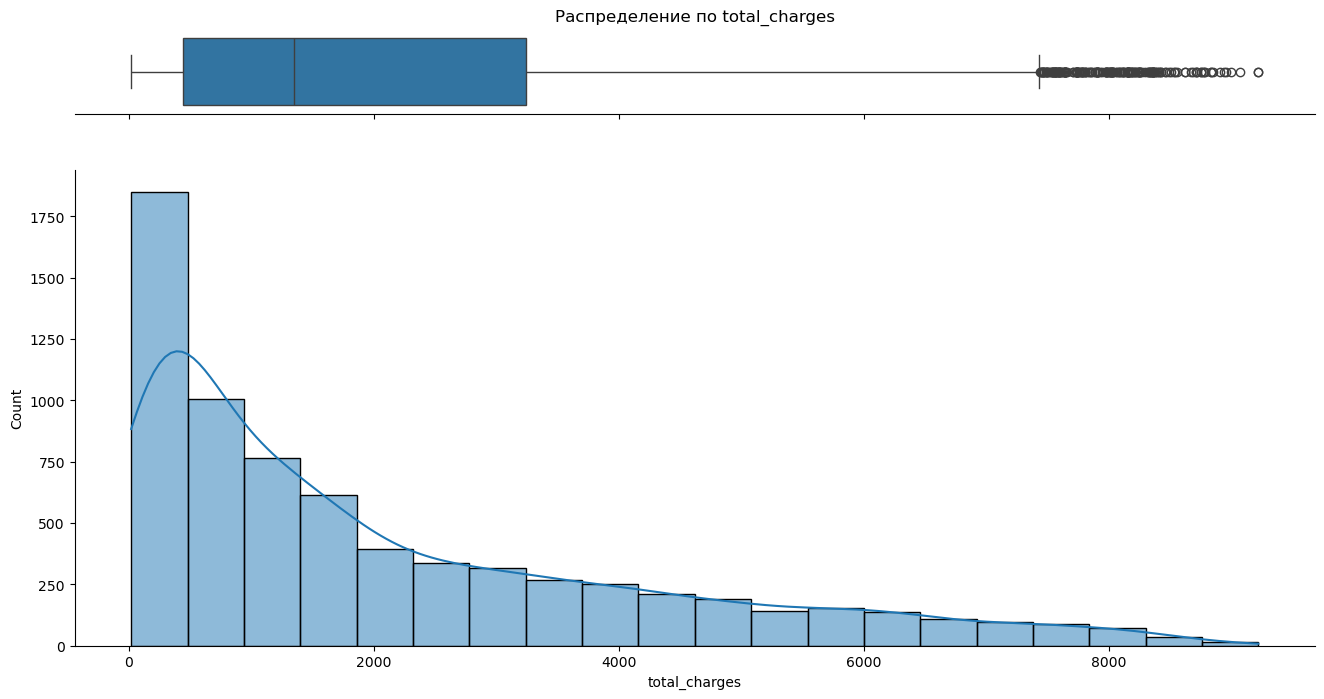

In [23]:
for col in num_cols_contracts:
    num_descr(contracts_df, col, 20)

In [24]:
contracts_df.query(f'total_charges.isna()')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


- Распределение по `montly_charges` выглядит многомодальным: наблюдаются пики в районе 20, 70 и 90. Вероятно, разные тарифные планы или количество услуг приводят к такому характеру данных.
- Распределение по `total_charges` имеет длинный правый хвост, что типично для накопленных значений. Большинство значений сконцентрировано в диапазоне от 0 до 2000. Наблюдаются выбросы на правой стороне, что указывает на клиентов с длительным сроком обслуживания или высокими затратами.  

##### Категориальные признаки

Распределение по type


array(['Month-to-month', 'One year', 'Two year'], dtype=object)

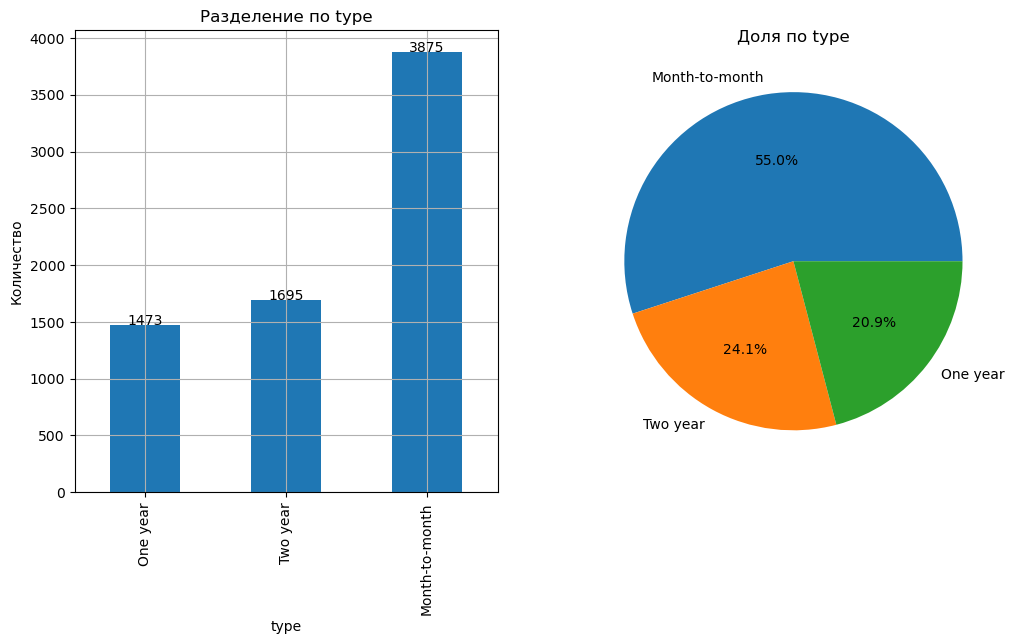

Распределение по paperless_billing


array(['Yes', 'No'], dtype=object)

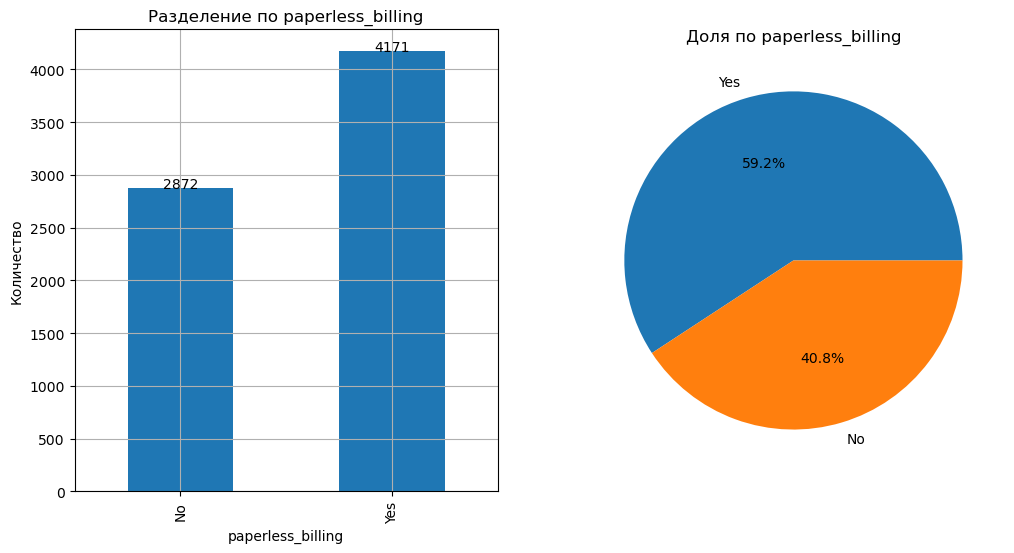

Распределение по payment_method


array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

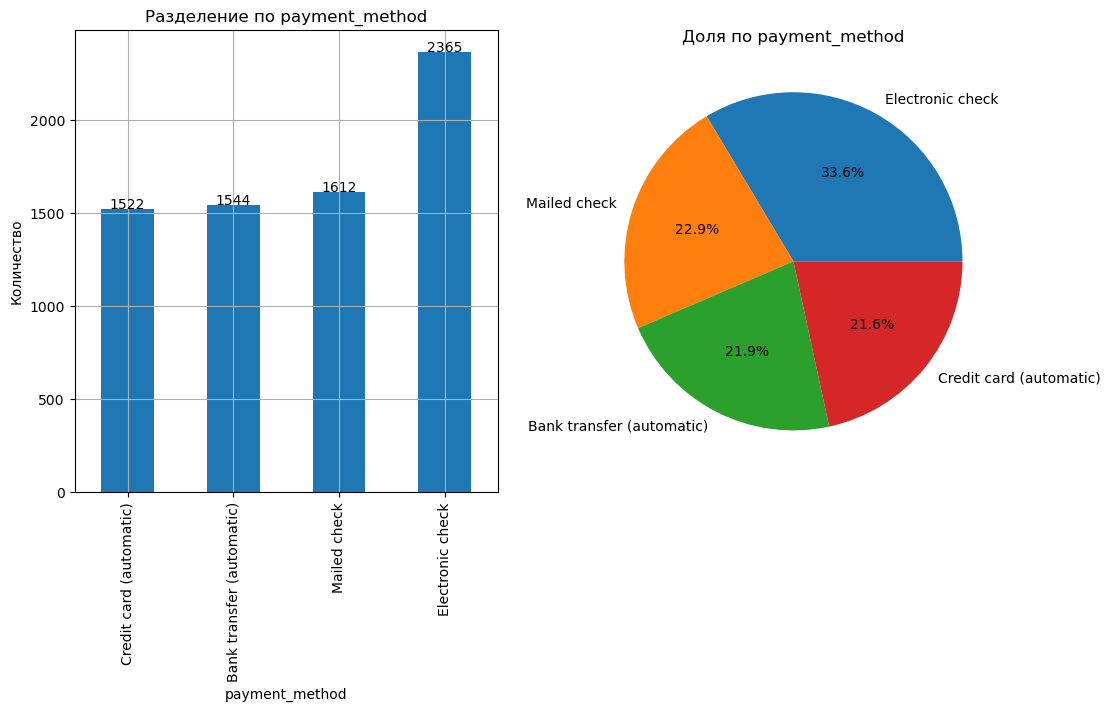

In [25]:
for col in cat_cols_contracts:
    cat_descr(contracts_df, col)

- Большинство получает счета в электронном виде
- Большинство предпочитает помесячную оплату
- 43% абонентов используют автоплатеж

##### ВременнЫе признаки

Распределение begin_date


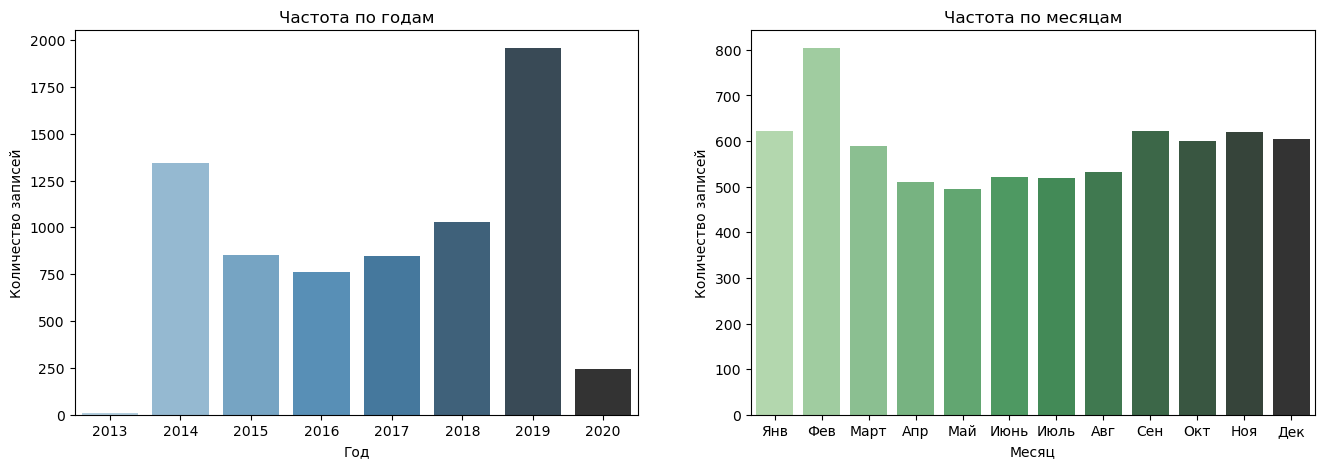

Распределение end_date


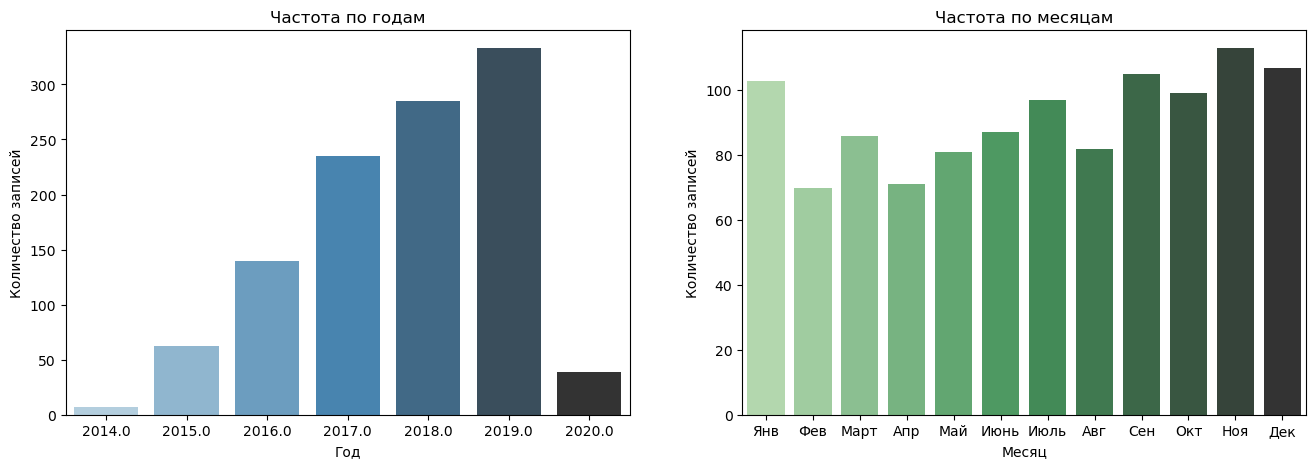

In [26]:
for col in ['begin_date', 'end_date']:
    print('Распределение', col)
    data_descr(contracts_df, col)

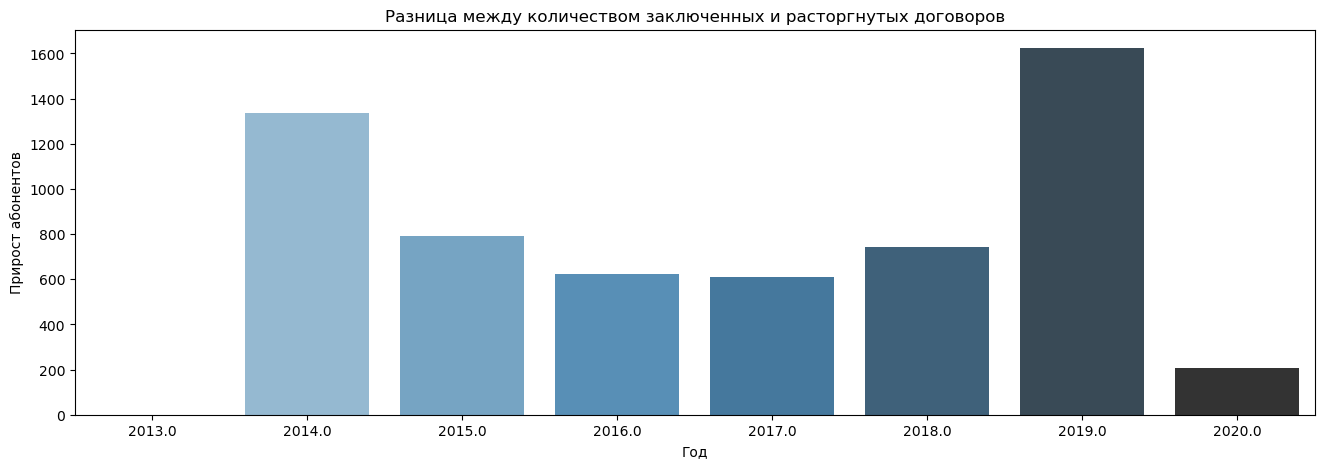

In [27]:
year_counts_start = contracts_df['begin_date'].dt.year.value_counts().sort_index()
year_counts_end = contracts_df['end_date'].dt.year.value_counts().sort_index()

year_counts = year_counts_start - year_counts_end

plt.figure(figsize=(16, 5))

sns.barplot(x=year_counts.index, y=year_counts.values, hue=year_counts.index, palette='Blues_d', legend=False)
plt.title('Разница между количеством заключенных и расторгнутых договоров')
plt.xlabel('Год')
plt.ylabel('Прирост абонентов')

plt.show()

На всем интервале динамика положительная. В 2019 наблюдается значительный рост числа новых абонентов.

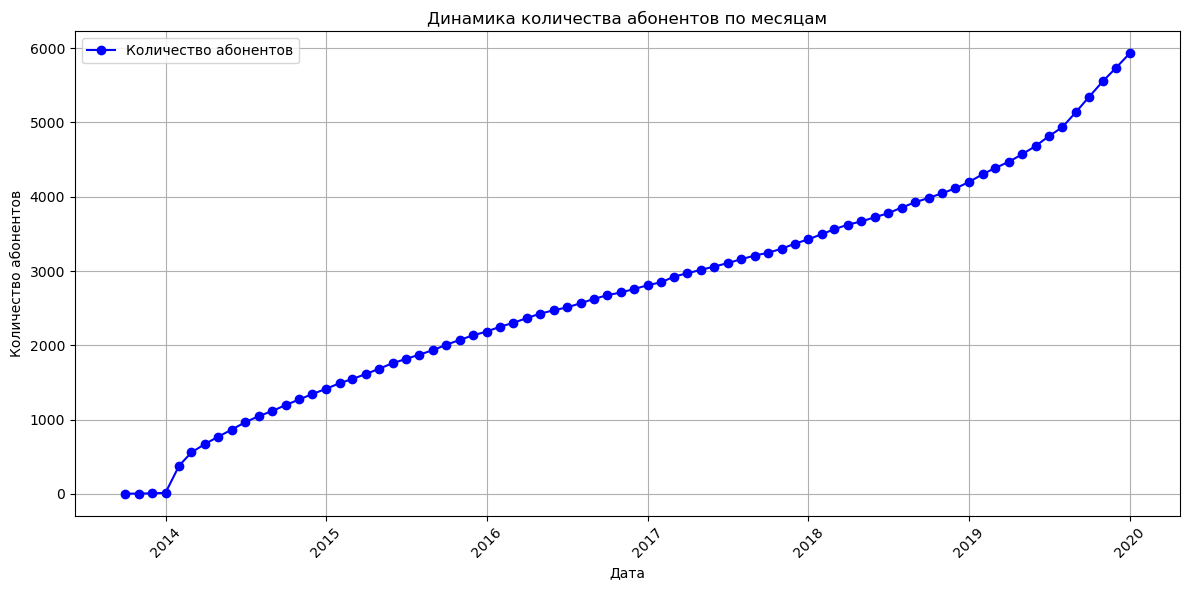

In [28]:
# Описание больше для меня, потому что я долго с этим графиком мучился.

# Преобразует столбец в периоды месяца. Например, дата 2019-05-15 станет периодом 2019-05
# Подсчитывает количество уникальных месяцев
# Сортирует результат по индексу
begin_year_month = contracts_df['begin_date'].dt.to_period('M').value_counts().sort_index()
end_year_month = contracts_df['end_date'].dt.to_period('M').value_counts().sort_index()

# Создает диапазон периодов между минимальной и максимальной датами начала и конца контрактов.
all_periods = pd.period_range(start=contracts_df['begin_date'].min().to_period('M'),
                              end=contracts_df['end_date'].max().to_period('M'), 
                              freq='M')

# Перепривязывает подсчитанные значения к полному диапазону месяцев. 
# Это гарантирует, что для каждого месяца в диапазоне будет запись, даже если контракты не начались или не закончились в этом месяце.
begin_year_month = begin_year_month.reindex(all_periods, fill_value=0)
end_year_month = end_year_month.reindex(all_periods, fill_value=0)

# Чистая динамика абонентов
net_change = begin_year_month - end_year_month

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(net_change.index.to_timestamp(), net_change.cumsum(), label='Количество абонентов', color='blue', marker='o')

plt.title('Динамика количества абонентов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество абонентов')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Количество пришедших абонентов превышает количество ушедших, общее количество абонентов растет.

##### contract_duration и целевой признак

В работе мы предсказываем расторгнет клиент договор или нет, значит для модели МО целевой метрикой будет признак расторгнут договор (1) или нет (0). Если в колонке end_date пропуск, считаем что договор действует.   

Вставил этот раздел сюда потому что изначально не хотел использовать `contract_duraton`, а потом при заполнении дат начала ломаться логика создания chur. В общем проще было поднять сюда, чем переписать).

In [29]:
# Добавление целевого признака churn (ушёл/не ушёл)
contracts_df['churn'] = contracts_df['end_date'].notna().astype(int)

In [30]:
# Заменяем NaT в столбце EndDate на 1 февраля 2020 года
contracts_df['end_date'].fillna(pd.Timestamp('2020-02-01'), inplace=True)

# Вычисляем ContractDuration
contracts_df['contract_duration'] = (contracts_df['end_date'] - contracts_df['begin_date']).dt.days

Описание столбца contract_duration
count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: contract_duration, dtype: float64


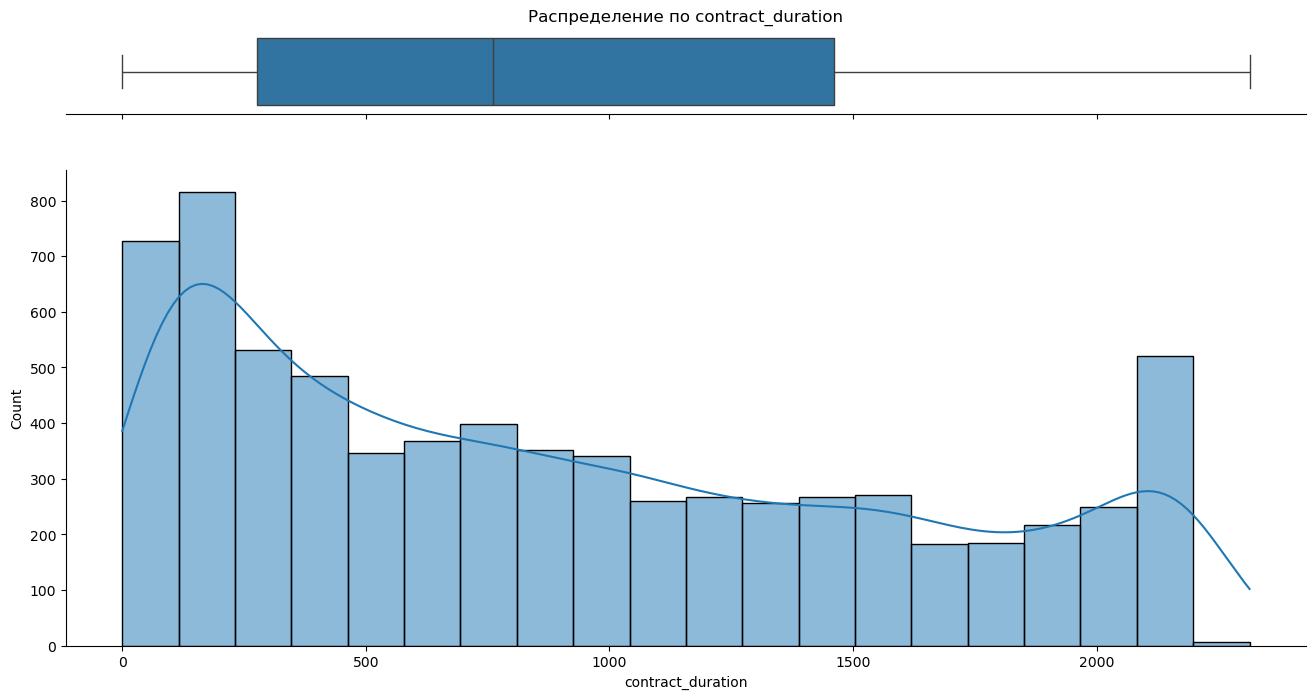

In [31]:
num_descr(contracts_df, 'contract_duration', 20)

#### personal_df

Распределение по gender


array(['Female', 'Male'], dtype=object)

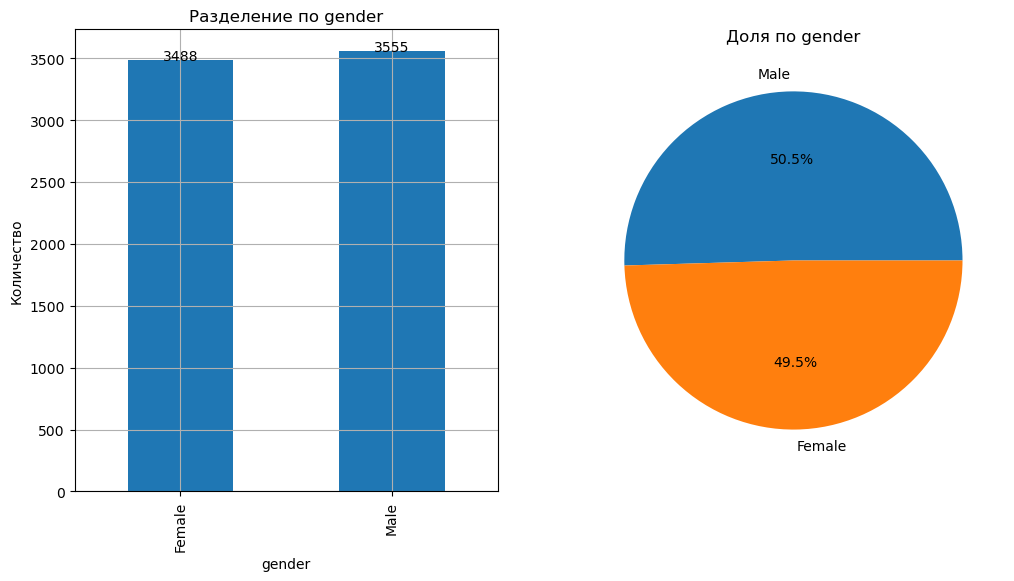

Распределение по senior_citizen


array(['0', '1'], dtype=object)

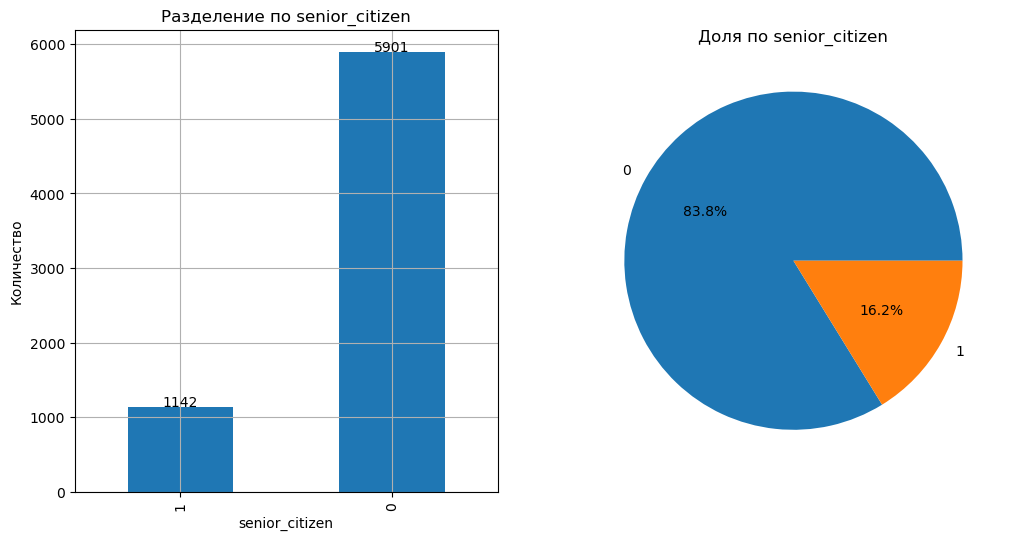

Распределение по partner


array(['Yes', 'No'], dtype=object)

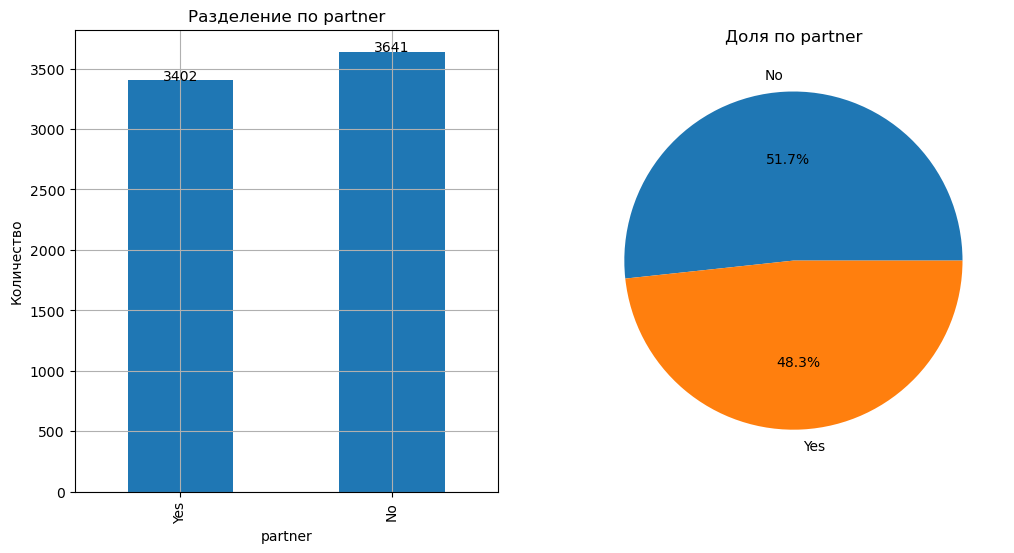

Распределение по dependents


array(['No', 'Yes'], dtype=object)

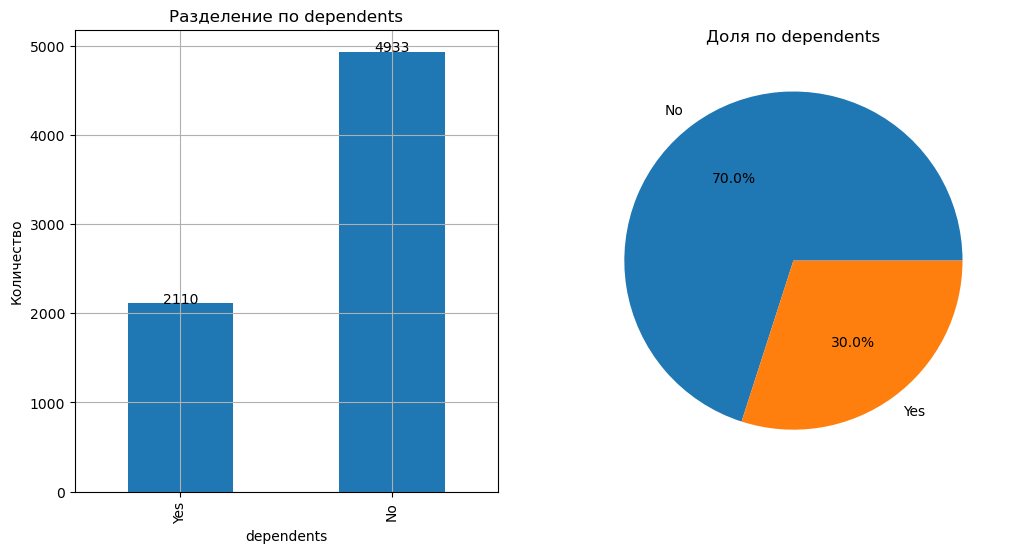

In [32]:
for col in [col for col in personal_df.columns if col != 'customer_id']:
    cat_descr(personal_df, col)

#### internet_df

Распределение по internet_service


array(['DSL', 'Fiber optic'], dtype=object)

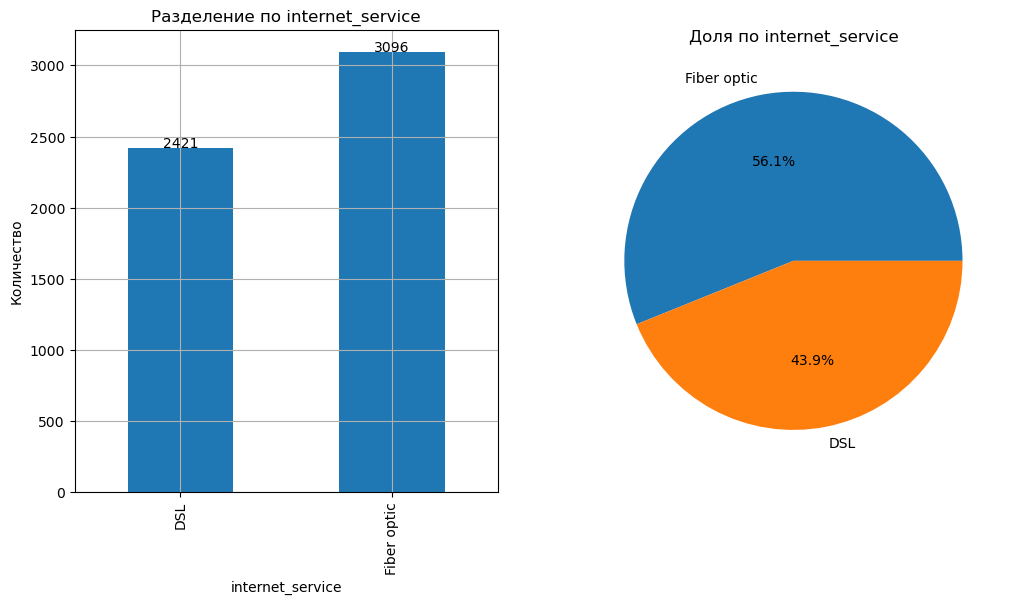

Распределение по online_security


array(['No', 'Yes'], dtype=object)

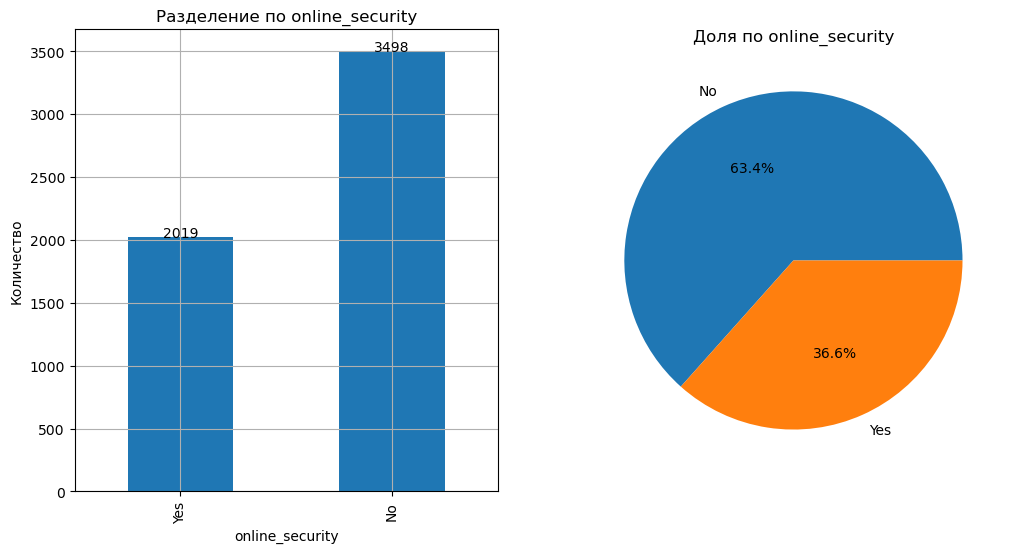

Распределение по online_backup


array(['Yes', 'No'], dtype=object)

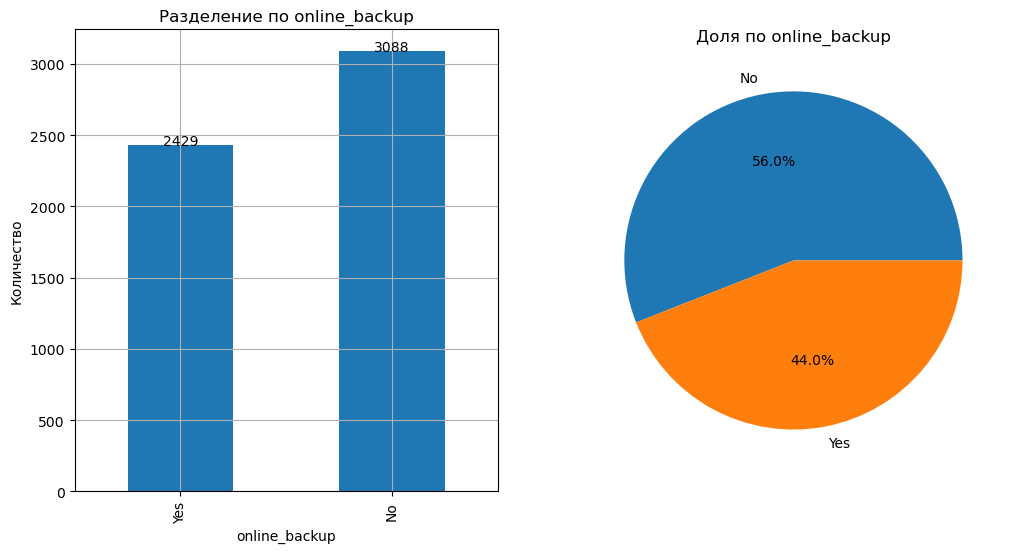

Распределение по device_protection


array(['No', 'Yes'], dtype=object)

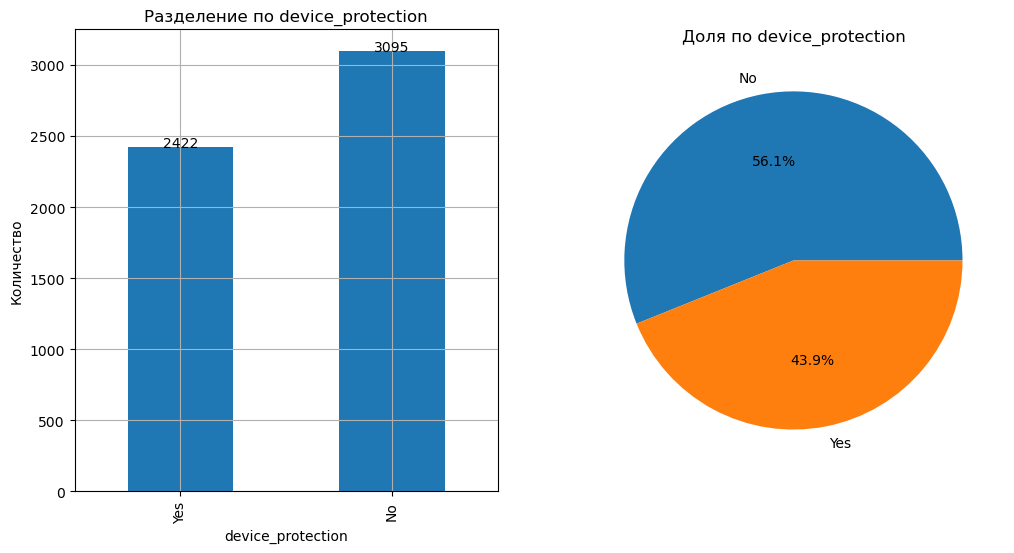

Распределение по tech_support


array(['No', 'Yes'], dtype=object)

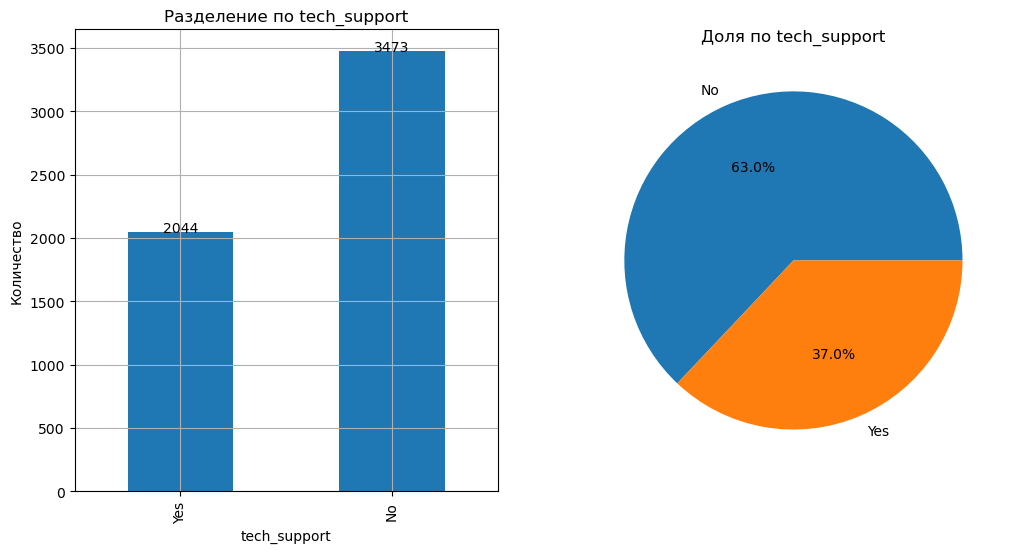

Распределение по streaming_tv


array(['No', 'Yes'], dtype=object)

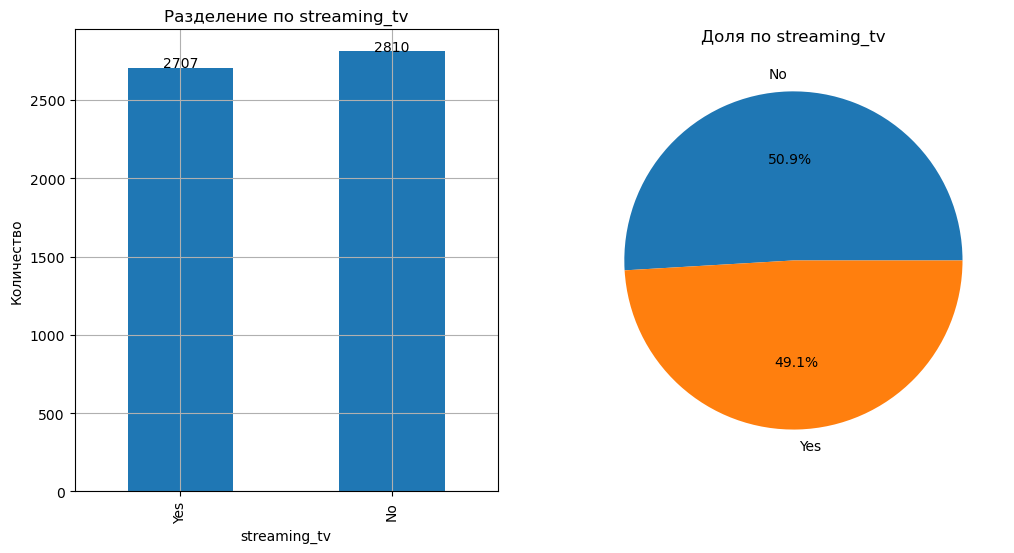

Распределение по streaming_movies


array(['No', 'Yes'], dtype=object)

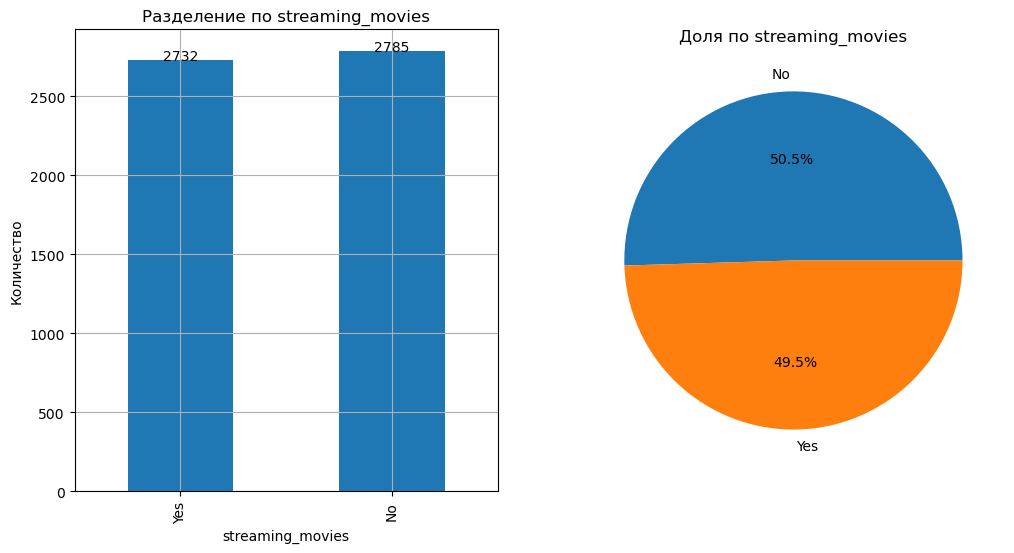

In [33]:
for col in [col for col in internet_df.columns if col != 'customer_id']:
    cat_descr(internet_df, col)

In [34]:
internet_df['num_services'] = internet_df.apply(
    lambda row: (row[['online_security', 'online_backup', 
                      'device_protection', 'tech_support', 
                      'streaming_tv', 'streaming_movies']] == 'Yes').sum(), 
                      axis=1)

Распределение по num_services


array([1, 2, 3, 0, 4, 5, 6], dtype=int64)

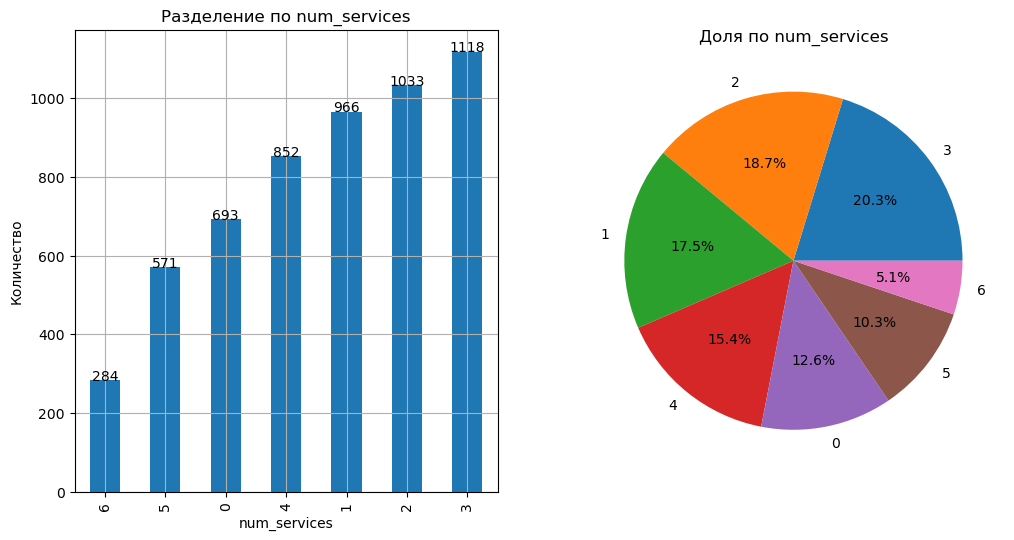

In [35]:
cat_descr(internet_df, 'num_services')

#### phone_df

Распределение по multiple_lines


array(['No', 'Yes'], dtype=object)

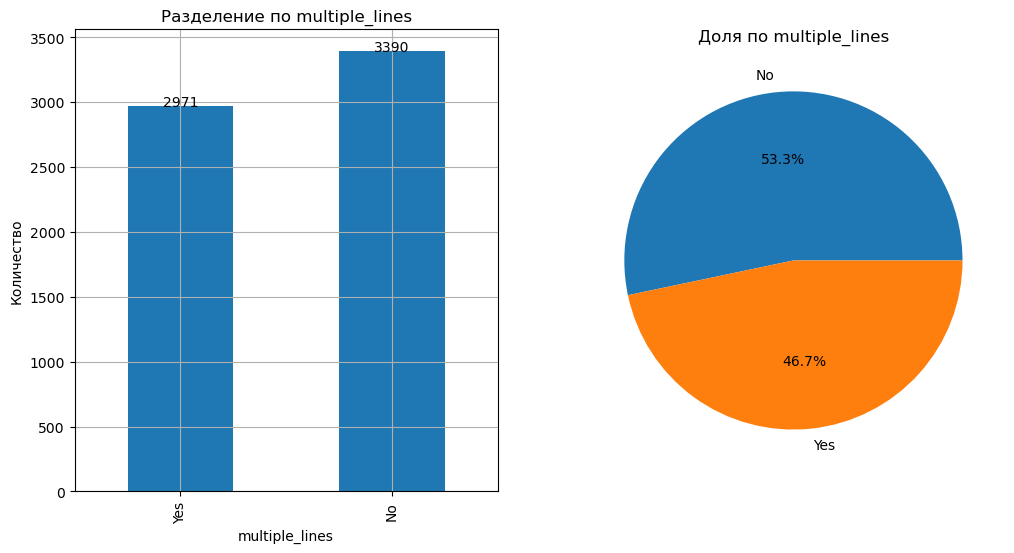

In [36]:
for col in [col for col in phone_df.columns if col != 'customer_id']:
    cat_descr(phone_df, col)

- типичный клиент - это мужчина или женщина, не пенсионер. Без детей.
- Пользуется услугами интернет, получая их по оптоволоконным каналам связи. Большинство клиентов пользутся 3 платными услугами.
- Предпочитает помесячную оплату, счета предпочитают получать в электронном виде, при этом автоплатеж использует примерно 42% абонентов.
- Лишь 12% всех абонентов не подключают доп услуги.

Можно отметить низкую популярность услуг (по сравнению с другими услугами) online security и tech support.

#### df_full. Объединение и анализ в разрезе действующих/расторгнутых договоров

In [37]:
df_full = (contracts_df
           .merge(personal_df, on='customer_id', how='left')
           .merge(internet_df, on='customer_id', how='left')
           .merge(phone_df, on='customer_id', how='left')
           )

df_full.info()
df_full.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int32         
 9   contract_duration  7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   object        
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,num_services,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,No,DSL,No,Yes,No,No,No,No,1.0,NaN


In [38]:
# Удаляем customer_id так как он не нужен и только мешается
df_full.drop('customer_id', axis=1, inplace=True)

In [39]:
# Заполняем пропуски:
# пропуски возникли у тех кто не успел заплатить, заполняем нулями
df_full.fillna({'total_charges': 0}, inplace=True)
df_full.fillna({'num_services': 0}, inplace=True)

# В категориальных данных пропуски возникли там где не подключена услуга:
for col in list(df_full.select_dtypes(include=['object', 'category']).columns):
    df_full.fillna({col: 'not_active'}, inplace=True)

df_full.isna().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
contract_duration    0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
num_services         0
multiple_lines       0
dtype: int64

##### Категориальные признаки

Распределение по churn


array([0, 1])

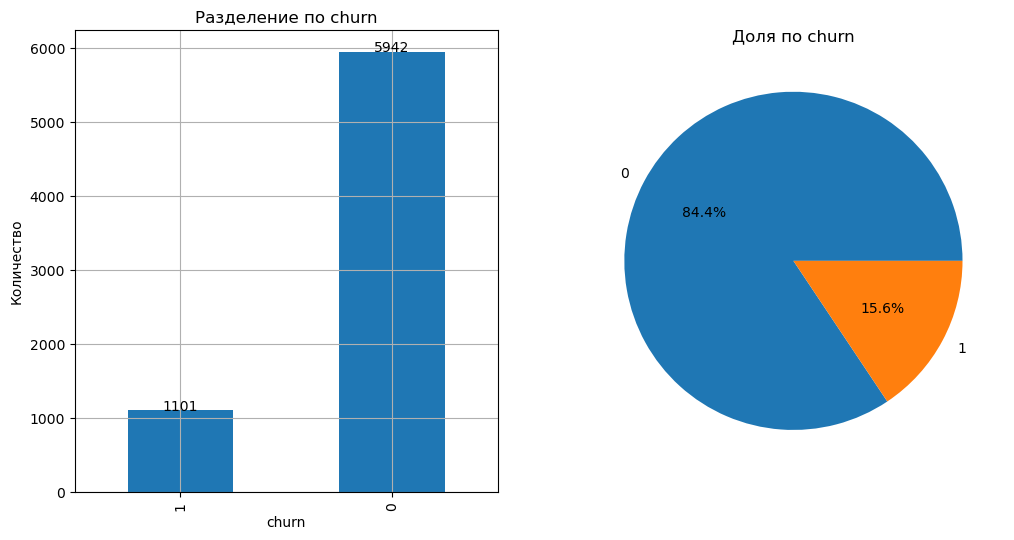

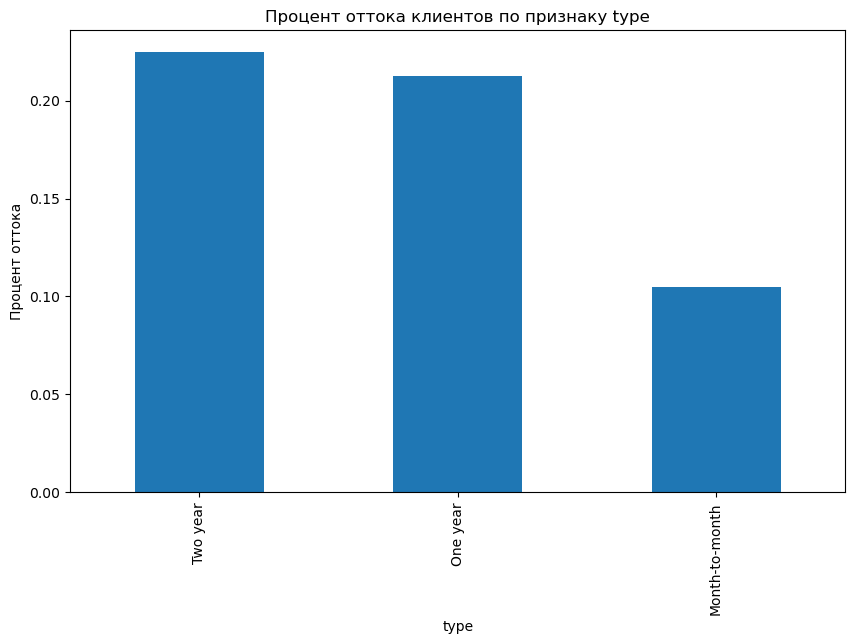

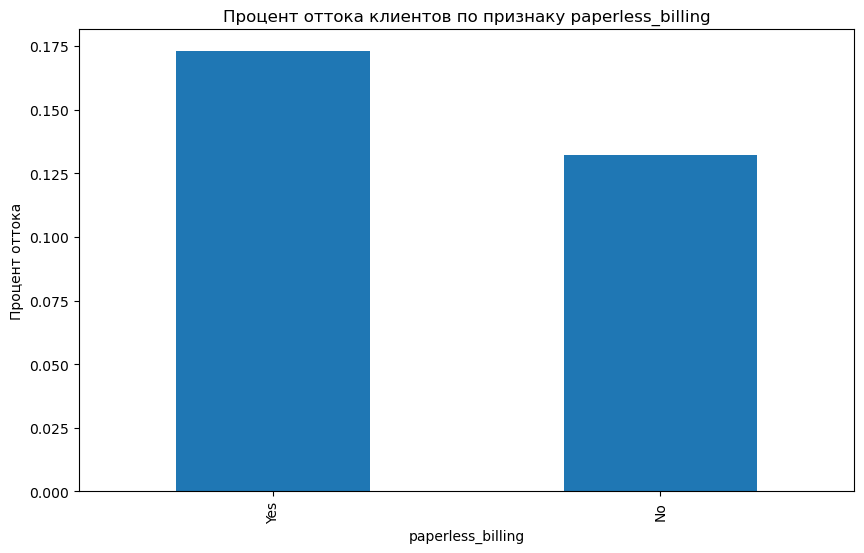

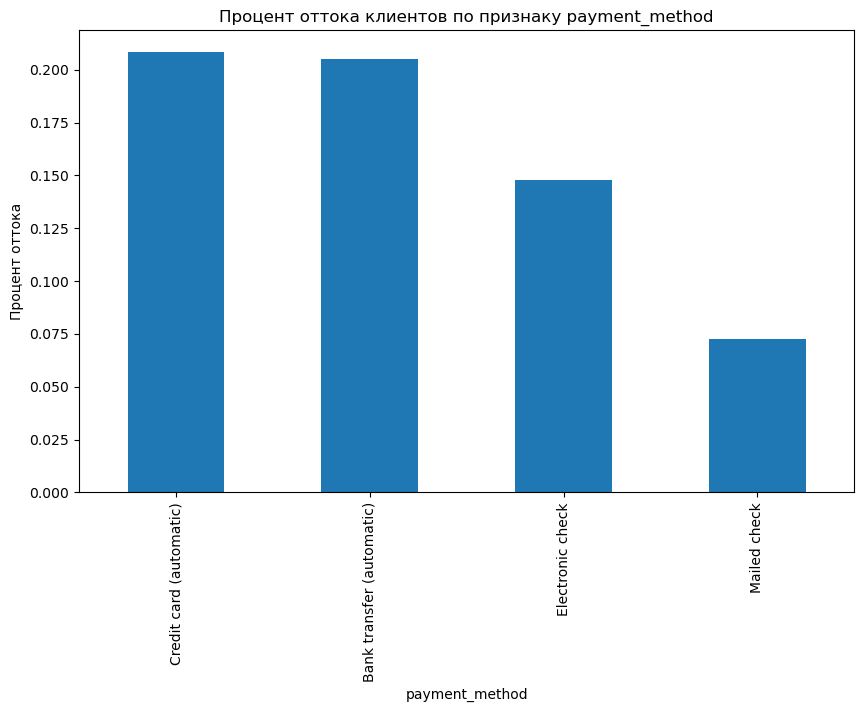

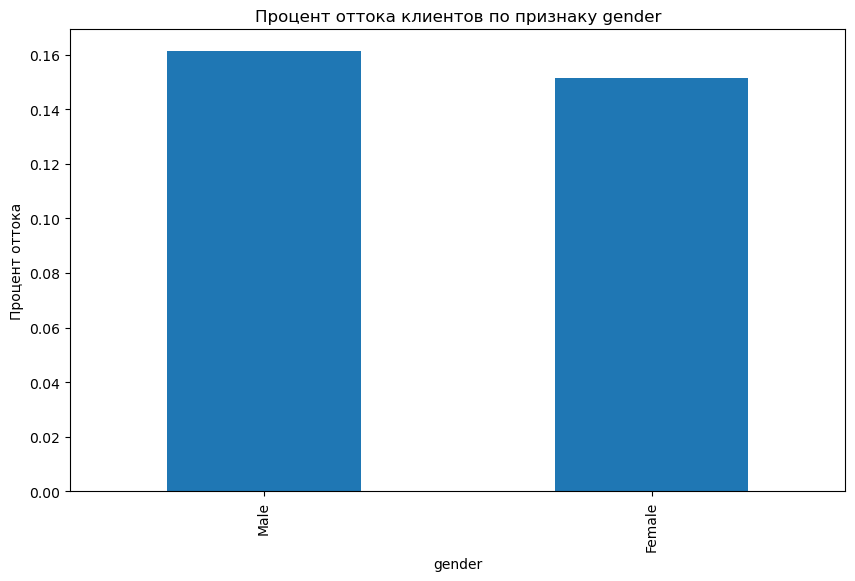

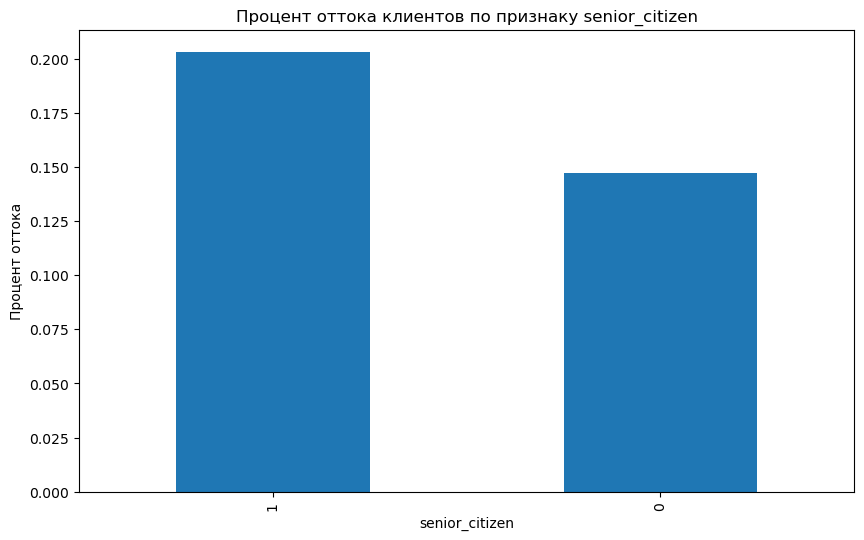

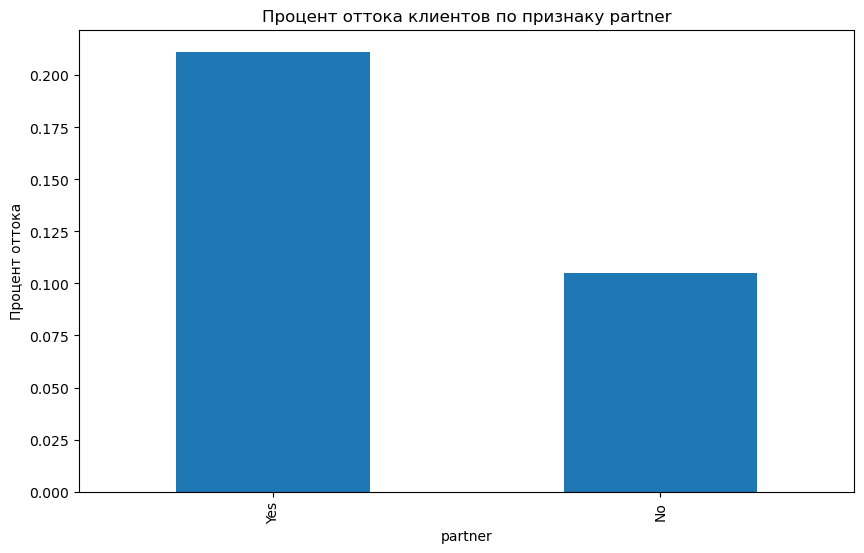

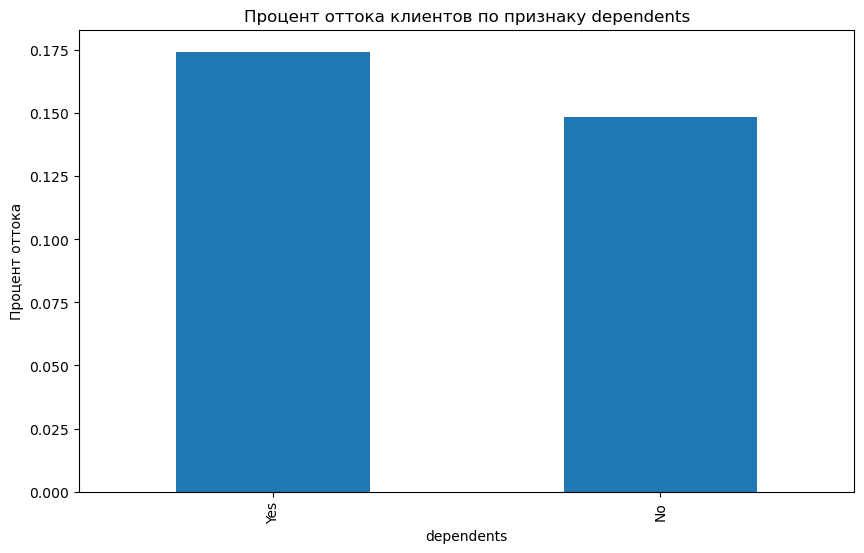

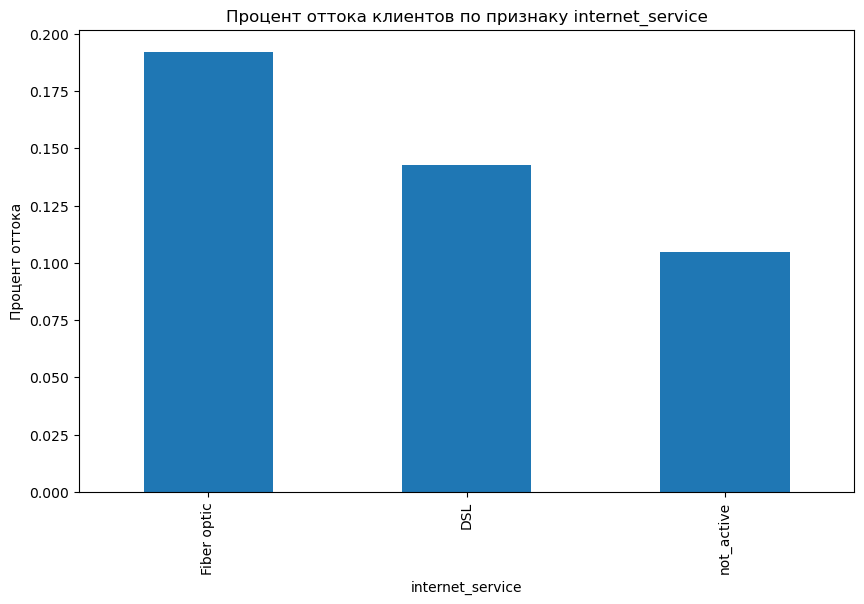

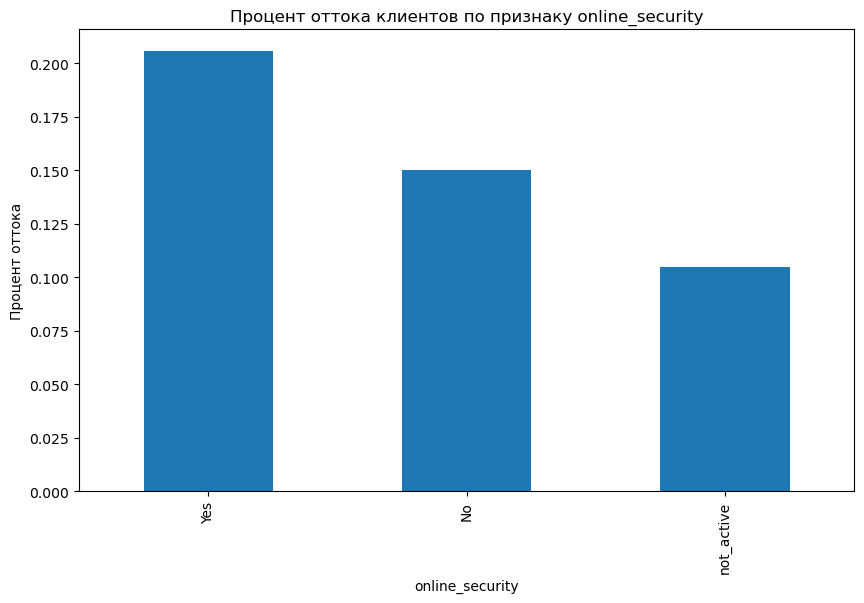

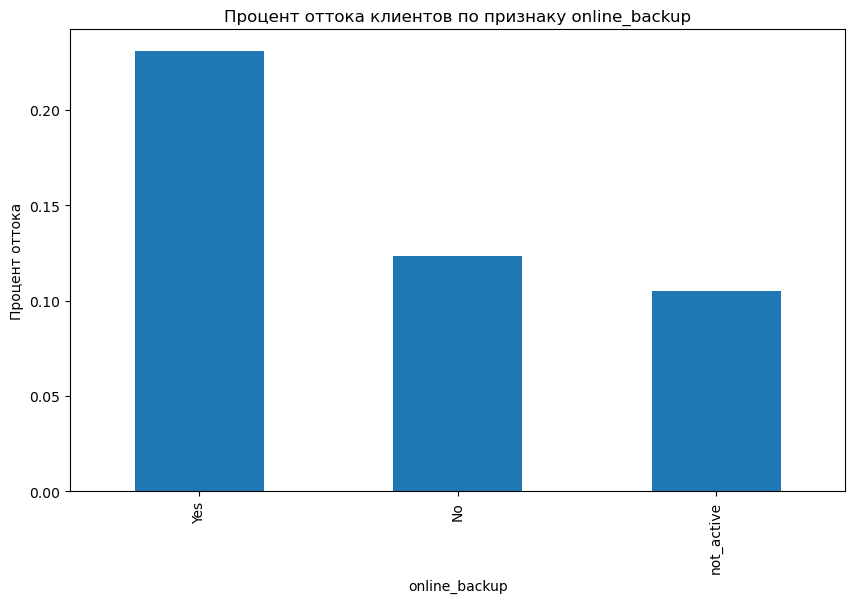

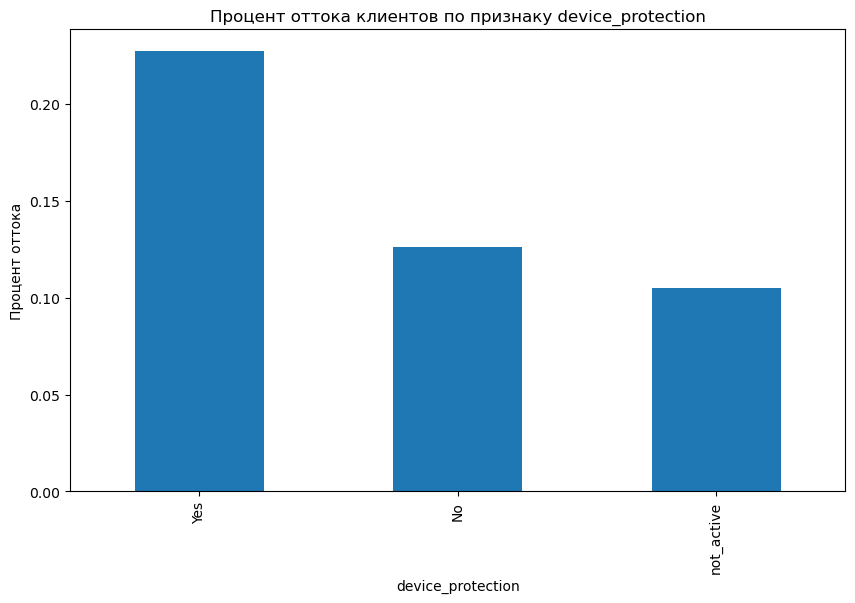

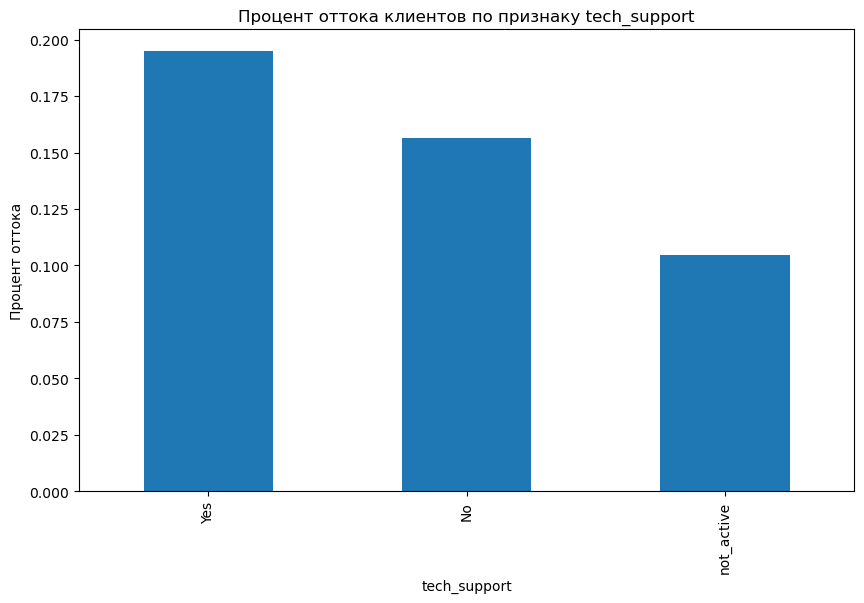

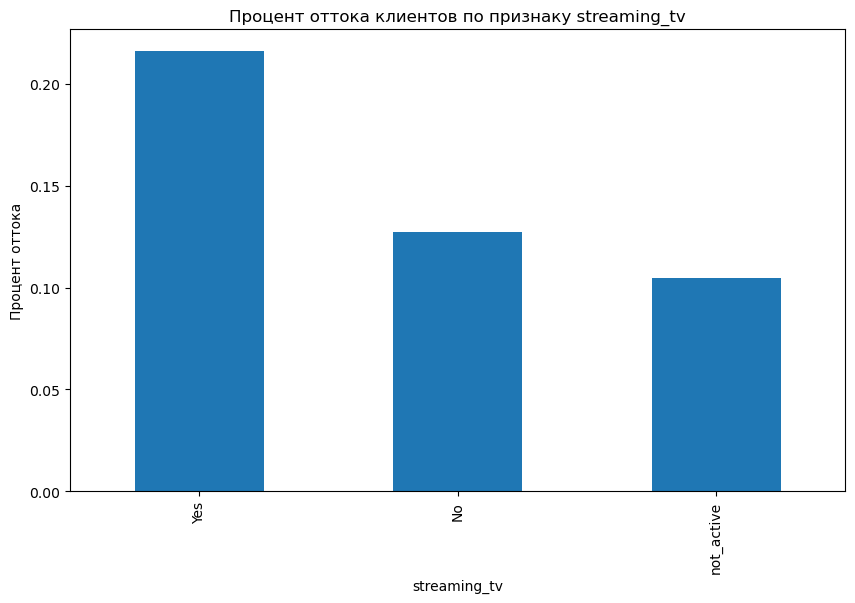

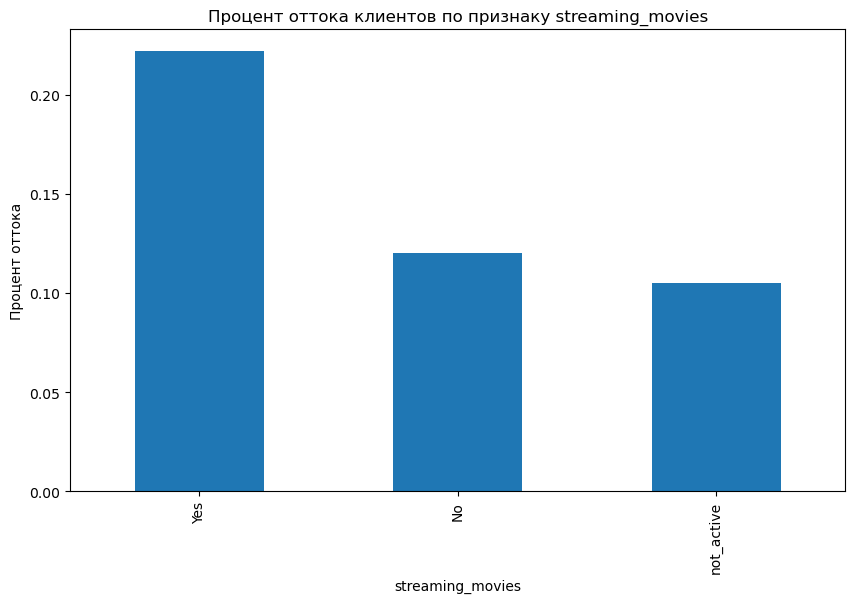

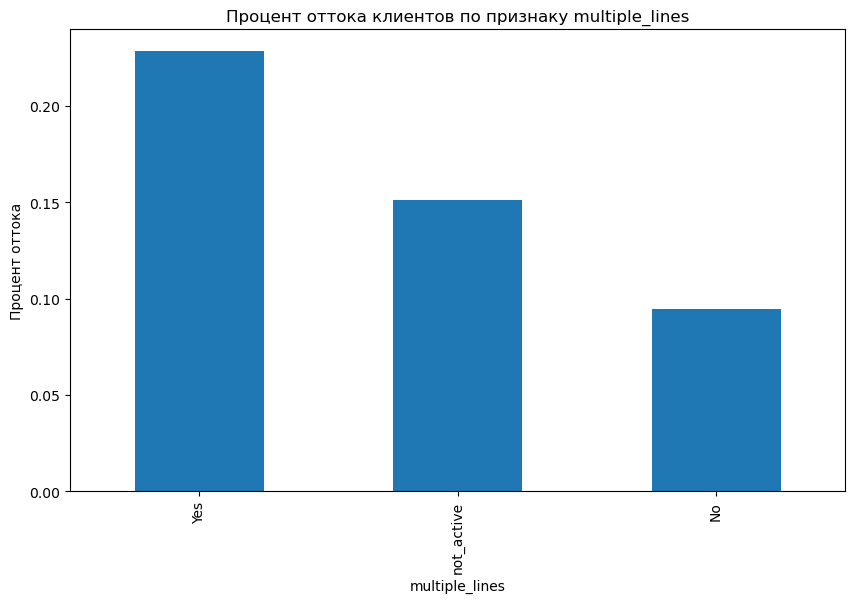

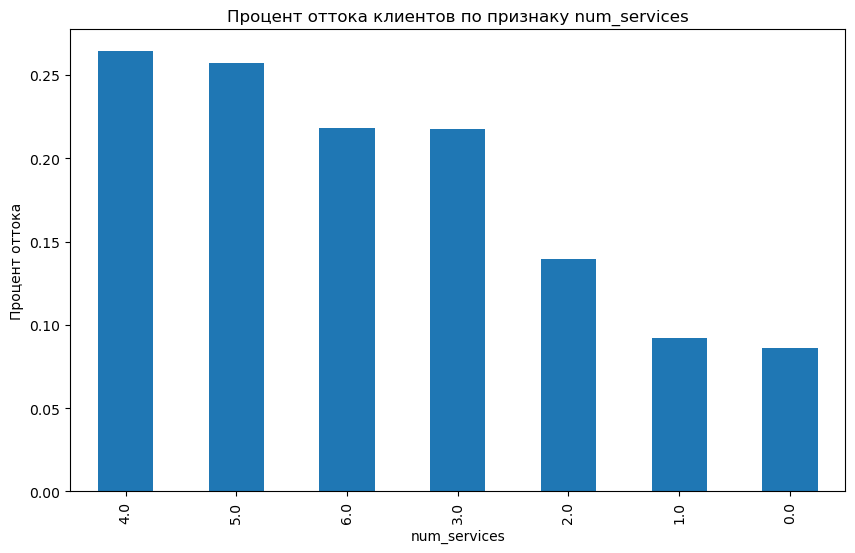

In [40]:
categorical_columns = list(df_full.select_dtypes(include=['object', 'category']).columns)
categorical_columns.append('num_services')

cat_descr(df_full, 'churn')

# Анализ соотношения по группам
for col in categorical_columns:
    churn_distribution = df_full.groupby(col)['churn'].mean().sort_values(ascending=False)
    churn_distribution.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Процент оттока клиентов по признаку {col}')
    plt.ylabel('Процент оттока')
    plt.show()

Можно заметить что процент оттока выше у пользователей с годовыми и двухгодовыми контрактами, подключенными доп услугами.  
У пользователей с 0-2 доп услуг отток заметно ниже чем у пользователей с 3-6 услугами.

##### Числовые признаки 

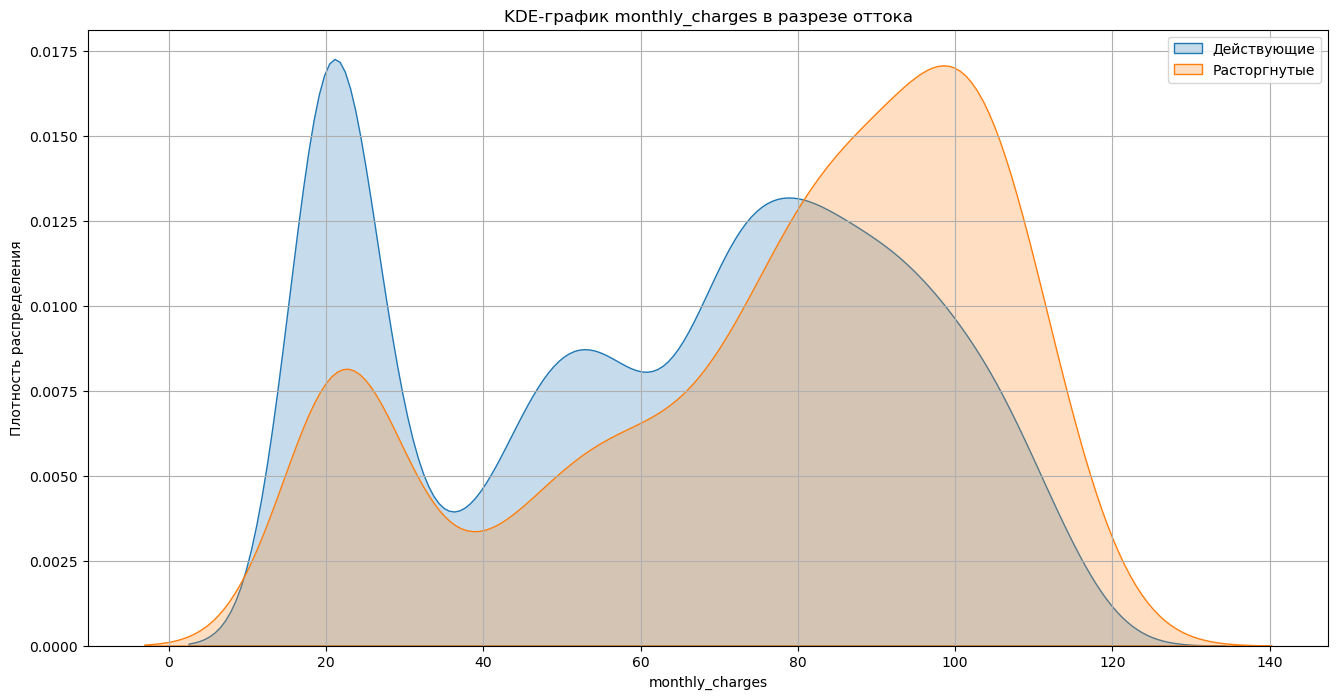

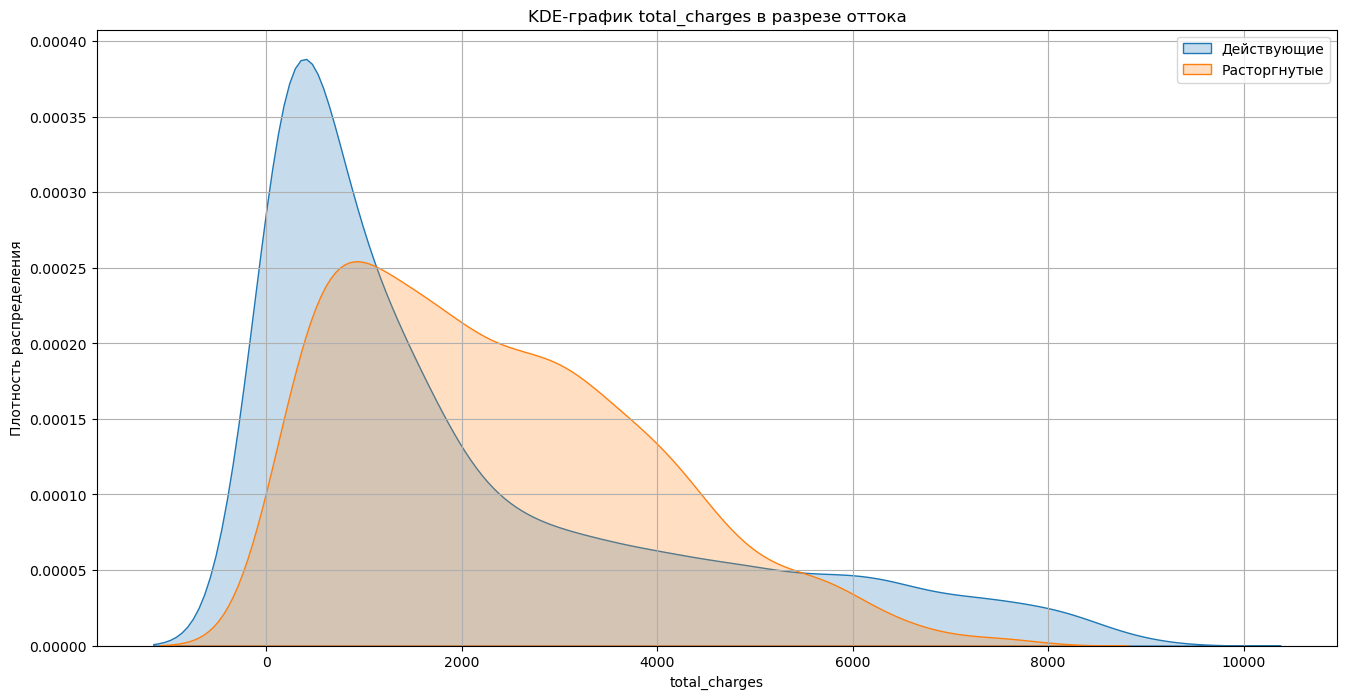

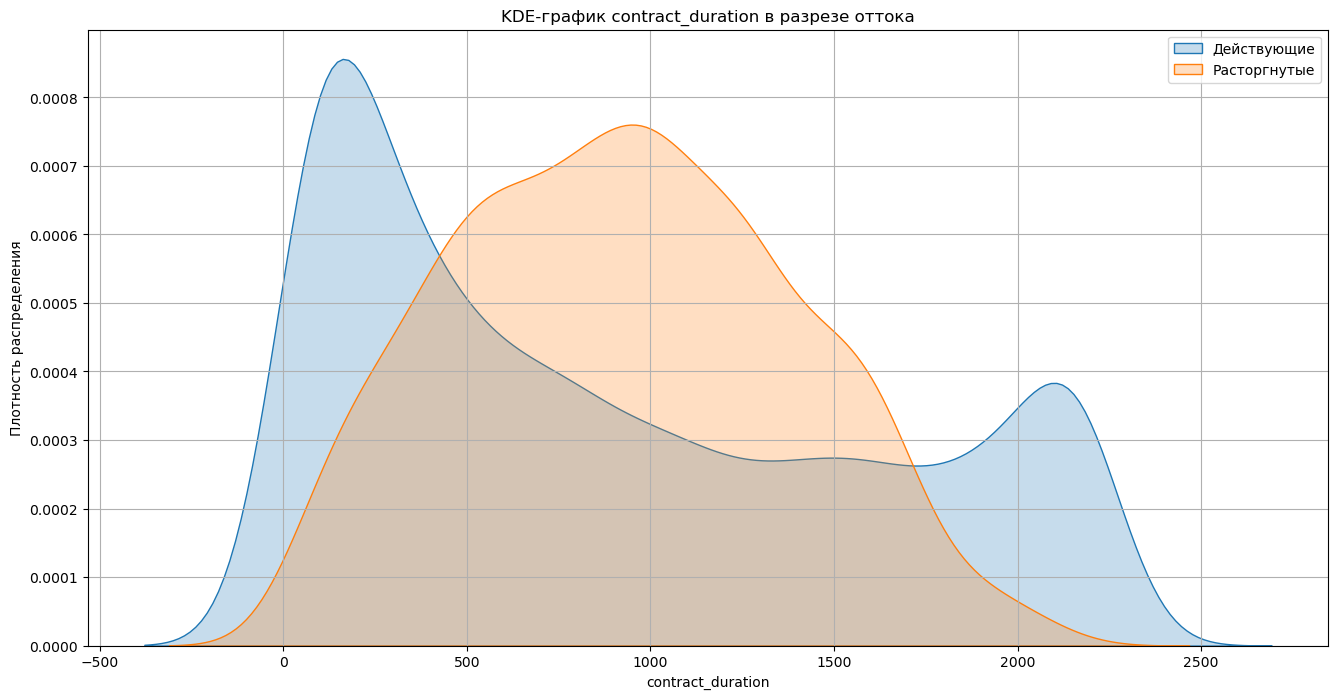

In [41]:
for col in ['monthly_charges', 'total_charges', 'contract_duration']:
    plt.figure(figsize=(16, 8))
    
    # Построение KDE-графика
    sns.kdeplot(data=df_full[df_full['churn'] == 0], x=col, label='Действующие', fill=True)
    sns.kdeplot(data=df_full[df_full['churn'] == 1], x=col, label='Расторгнутые', fill=True)
    
    plt.xlabel(col)
    plt.ylabel('Плотность распределения')
    plt.title(f'KDE-график {col} в разрезе оттока')
    plt.legend()
    plt.grid()
    plt.show()


По графикам видно что отток среди абонентов с большими платежами выше. Абоненты чаще уходят после 500-1500 дней пользования услугами. И почти не уходят если пользуются услугами уже более 2000 дней.

#### Выводы по EDA

По числовым признакам:
- Распределение по `montly_charges` выглядит многомодальным: наблюдаются пики в районе 20, 70 и 90. Вероятно, разные тарифные планы или количество услуг приводят к такому характеру данных.
- Распределение по `total_charges` имеет длинный правый хвост, что типично для накопленных значений. Большинство значений сконцентрировано в диапазоне от 0 до 2000. Наблюдаются выбросы на правой стороне, что указывает на клиентов с длительным сроком обслуживания или высокими затратами.  
- Распределние по `num_services` выглядит нормальным или близким к нормальному. Большинство клиентов пользуются дополнительно 1-3 услугами.
- Распределение по `contract_duration` показывает большое количество новых клиентов (до года).

Стоит обратить внимание на большой отток клиентов в высокими месячными платежами, этим можно так же объяснить отток клиентов с большим количеством платных услуг (возможно рассмотреть скидки на пакеты услуг).  

По категориальным данным:
- типичный клиент - это мужчина или женщина, не пенсионер. Без детей.
- Пользуется услугами интернет, получая их по оптоволоконным каналам связи. Большинство клиентов пользутся 3 платными услугами.
- Предпочитает помесячную оплату, счета предпочитают получать в электронном виде, при этом автоплатеж использует примерно 42% абонентов.
- Лишь 12% всех абонентов не подключают доп услуги.

Можно отметить низкую популярность услуг (по сравнению с другими услугами) online security и tech support.

Количество абонентов растет. Это надо учесть при планировании затрат на поддержку/модернизацию оборудования и ожидать растущий объем обращений пользователей. 

In [42]:
numeric_columns, categorical_columns = get_col_type(df_full)

portrait = pd.DataFrame(columns=['Не отток', 'Отток', 'Разница'])

for col in numeric_columns:
    if col not in ['churn']:
        churn_0_value = df_full[df_full['churn'] == 0][col].mean().round(2)
        churn_1_value = df_full[df_full['churn'] == 1][col].mean().round(2)
        difference = churn_0_value - churn_1_value
        portrait.loc[col] = [churn_0_value, churn_1_value, difference]

# Обрабатываем категориальные столбцы
for col in categorical_columns:
    if col not in ['customer_id', 'begin_date', 'end_date']:
        churn_0 = df_full[df_full['churn'] == 0][col].mode().iloc[0]
        churn_1 = df_full[df_full['churn'] == 1][col].mode().iloc[0]
        portrait.loc[col] = [churn_0, churn_1, None]

display(portrait)

Числовые столбцы: ['monthly_charges', 'total_charges', 'churn', 'contract_duration', 'num_services']
Категориальные столбцы: ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


,Не отток,Отток,Разница
monthly_charges,62.76,75.55,-12.79
total_charges,2067.87,2371.38,-303.51
contract_duration,893.68,924.86,-31.18
num_services,1.89,2.83,-0.94
type,Month-to-month,Month-to-month,None
paperless_billing,Yes,Yes,None
payment_method,Electronic check,Electronic check,None
gender,Male,Male,None
senior_citizen,0,0,None
partner,No,Yes,None


Средний ушедший клиент тратит в месяц почти на 20% больше, чем не ушедший.  
У среднего не ушедшего клиента нет подключенных доп. услуг, что делает ежемесячную плату ниже.

### Матрица корреляции и отбор признаков

In [43]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']

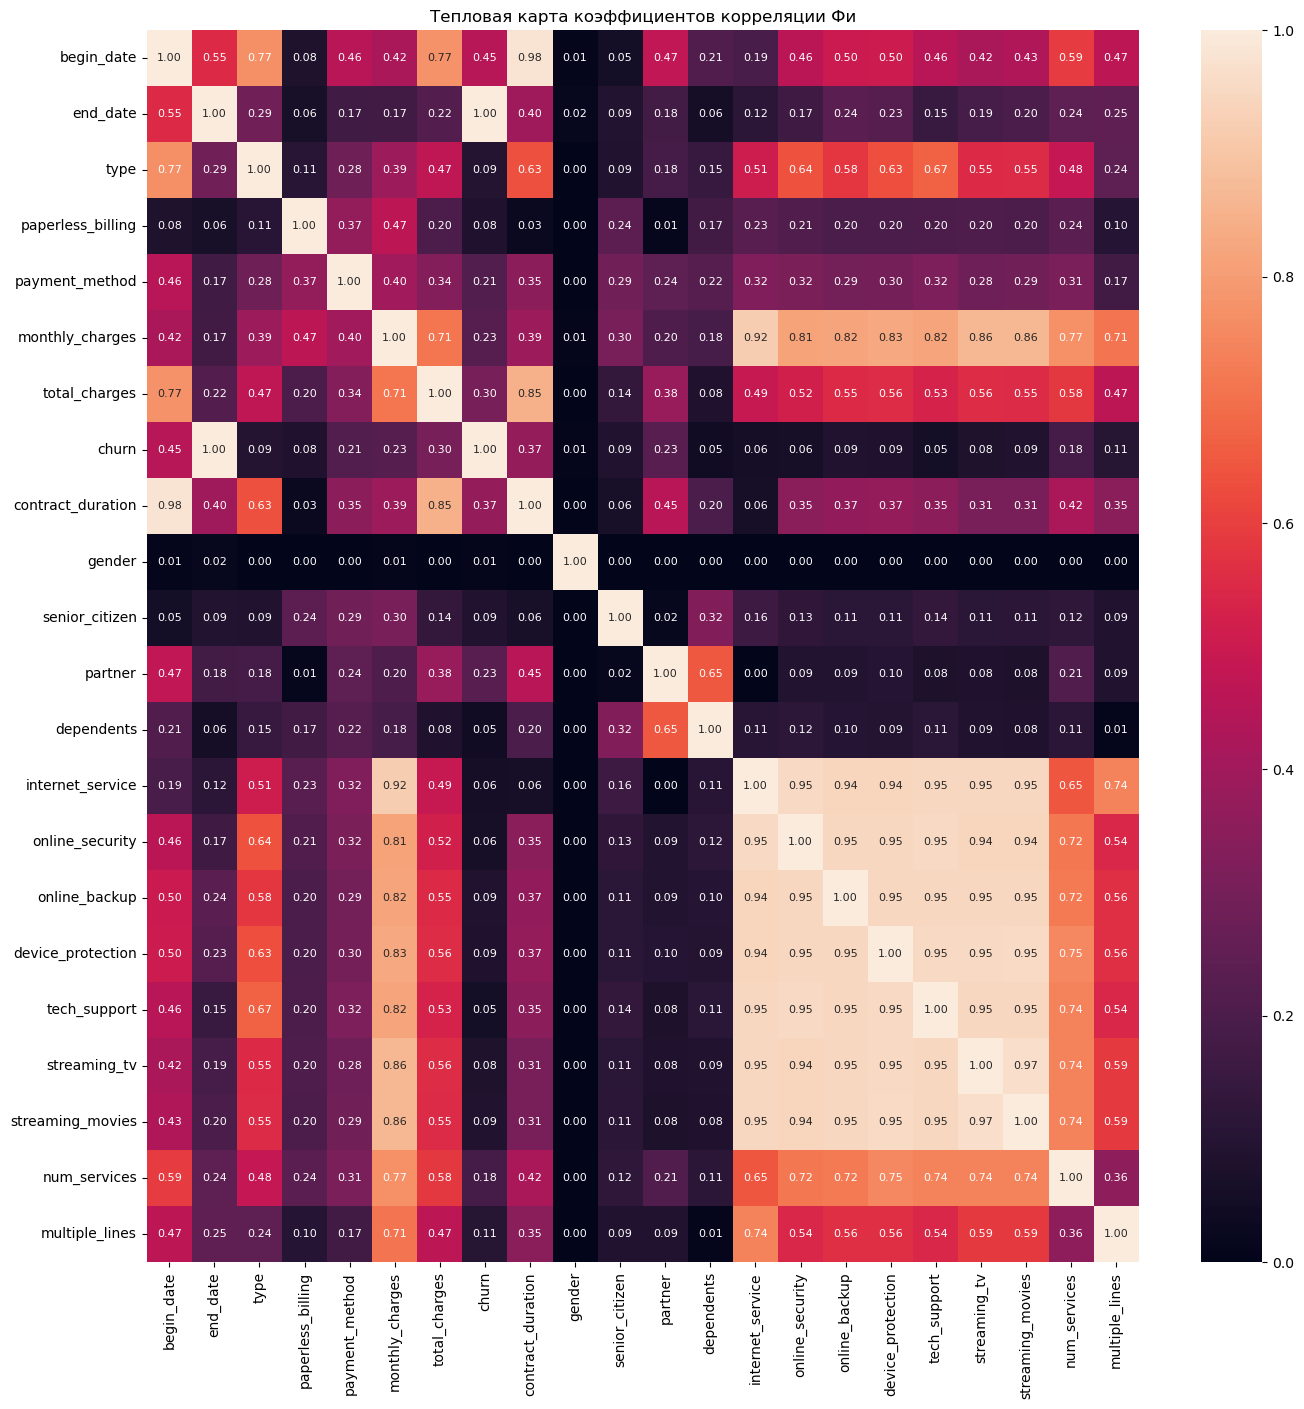

In [44]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_full
           .phik_matrix(interval_cols = interval_cols),
            annot=True, fmt='.2f', annot_kws={'fontsize':8})
plt.title('Тепловая карта коэффициентов корреляции Фи');

Учитывая проведенный анализ и матрицу корреляции удаляем следующие признаки:  
- все что связано с датой: `begin_date`, `end_date`;
- `total_charges` - чем дольше человек был клиентом, тем выше у него накопленная сумма. Оставим только `contract_duration`;  
- gender - по анализу можно предположить что от пола не зависит веротяность расторжения договора;
- вместо столбцов с перечисленными сервисами будет использовать агрегированный `num_services`;  

In [45]:
df_ml = df_full[['type', 'paperless_billing', 'payment_method',
                 'monthly_charges', 'senior_citizen', 'partner',
                 'dependents', 'internet_service', 'num_services',
                 'multiple_lines', 'contract_duration', 'churn']].copy()

df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   senior_citizen     7043 non-null   object 
 5   partner            7043 non-null   object 
 6   dependents         7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   num_services       7043 non-null   float64
 9   multiple_lines     7043 non-null   object 
 10  contract_duration  7043 non-null   int64  
 11  churn              7043 non-null   int32  
dtypes: float64(2), int32(1), int64(1), object(8)
memory usage: 632.9+ KB


### Обучение модели

#### Предобработка

При слиянии таблиц образовались пропуски в местах где абонент не пользуется определенным видом услуг. Обработка пропусков будет происходить автоматически пайплайном.  
Допущение: данные вносятся корректно и необходимо обрабатывать только пропуски, возникающие при отсутствии подключенной услуги.

In [46]:
X = df_ml.drop(['churn'], axis=1)
y = df_ml['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

In [47]:
numeric_features, categorical_features = get_col_type(X_train)

Числовые столбцы: ['monthly_charges', 'num_services', 'contract_duration']
Категориальные столбцы: ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'multiple_lines']


In [48]:
# Пропуски в числовых данных есть только в 'num_services', у тех кто не пользуется интернетом. Поставим заглушку.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())])


# Пропуски в категориальных данных возникают в тех же местах, поставим заглушку
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not_active')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#### Деревья

In [49]:
# Создание пайплайна для случайного леса (или решающего дерева)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=rs))])

# Гиперпараметры для случайного леса
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [2, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

# GridSearchCV для случайного леса
rf_grid_search = GridSearchCV(rf_pipeline, 
                              rf_param_grid, 
                              cv=5, 
                              n_jobs=-1, 
                              verbose=2,
                              scoring='roc_auc')


In [50]:
rf_grid_search.fit(X_train, y_train)

print('Лучшие гиперпараметры:', rf_grid_search.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации: {rf_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие гиперпараметры: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Лучшее значение ROC-AUC на кросс-валидации: 0.8281


#### Catboost

In [51]:
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(eval_metric='AUC', random_state=rs, verbose=0))])

# Гиперпараметры для CatBoost
cb_param_grid = {
    'classifier__n_estimators': [300, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV для CatBoost
cb_grid_search = GridSearchCV(cb_pipeline, 
                              cb_param_grid, 
                              cv=5, 
                              n_jobs=-1,
                              verbose=2,
                              scoring='roc_auc')

In [52]:
cb_grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", cb_grid_search.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации: {cb_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие гиперпараметры: {'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Лучшее значение ROC-AUC на кросс-валидации: 0.9279


#### Нейросеть

In [53]:
# Преобразуем данные и сохраняем их в тензорах
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
# 2. Определение многослойной модели
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout):
        super(Net, self).__init__()
        layers = []
        in_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



In [55]:
# 3. Функция для Optuna
def objective(trial):
    # Параметры ранней остановки и количество эпох
    num_epochs = 50
    patience = 5
    
    # Параметры для подбора
    num_layers = trial.suggest_int('num_layers', 2, 4)
    hidden_dims = [trial.suggest_int(f'hidden_dim_{i}', 4, 32) for i in range(num_layers)]
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0, 0.2)

    kf = KFold(n_splits=5, shuffle=True, random_state=rs)
    best_auc_scores = []

    for train_index, val_index in kf.split(X_train_processed):
        X_fold_train_tensor = torch.tensor(X_train_processed[train_index], dtype=torch.float32)
        y_fold_train_tensor = torch.tensor(y_train.values[train_index], dtype=torch.float32)
        X_fold_val_tensor = torch.tensor(X_train_processed[val_index], dtype=torch.float32)
        y_fold_val_tensor = torch.tensor(y_train.values[val_index], dtype=torch.float32)

        train_dataset = TensorDataset(X_fold_train_tensor, y_fold_train_tensor)
        val_dataset = TensorDataset(X_fold_val_tensor, y_fold_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

        model = Net(input_dim=X_train_tensor.shape[1], hidden_dims=hidden_dims, dropout=dropout)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        wait = 0
        best_auc_fold = float('-inf')

        for epoch in range(num_epochs):
            model.train()

            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Оценка на валидации
            model.eval()
            y_preds = []
            y_true = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch).squeeze()
                    y_preds.extend(outputs.numpy())
                    y_true.extend(y_batch.numpy())

            val_auc = roc_auc_score(y_true, y_preds)
            
            if val_auc > best_auc_fold:
                best_auc_fold = val_auc
                wait = 0
            else:
                wait += 1

            if wait >= patience:
                break
        
        best_auc_scores.append(best_auc_fold)

    # Возвращаем среднее значение AUC на кросс-валидации для Optuna
    return np.mean(best_auc_scores)

In [56]:
# 4. Оптимизация с Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Лучшие гиперпараметры:', study.best_params)
print(f'Лучшее значение ROC-AUC: {study.best_value:.4f}')

[I 2024-11-17 13:36:01,429] A new study created in memory with name: no-name-d5b092fc-b9c4-4c64-9c24-c1d0e591050c
[I 2024-11-17 13:36:19,673] Trial 0 finished with value: 0.8348806708342871 and parameters: {'num_layers': 3, 'hidden_dim_0': 13, 'hidden_dim_1': 32, 'hidden_dim_2': 24, 'lr': 0.009025858605750416, 'dropout': 0.11435502283024582}. Best is trial 0 with value: 0.8348806708342871.
[I 2024-11-17 13:36:32,485] Trial 1 finished with value: 0.8339466363858714 and parameters: {'num_layers': 2, 'hidden_dim_0': 7, 'hidden_dim_1': 24, 'lr': 0.006614270441833218, 'dropout': 0.09185984147807713}. Best is trial 0 with value: 0.8348806708342871.
[I 2024-11-17 13:36:58,602] Trial 2 finished with value: 0.825952806135591 and parameters: {'num_layers': 2, 'hidden_dim_0': 12, 'hidden_dim_1': 16, 'lr': 0.0005326051968327482, 'dropout': 0.08738349955332017}. Best is trial 0 with value: 0.8348806708342871.
[I 2024-11-17 13:38:25,910] Trial 3 finished with value: 0.8010204581867608 and parameters

Лучшие гиперпараметры: {'num_layers': 3, 'hidden_dim_0': 18, 'hidden_dim_1': 23, 'hidden_dim_2': 15, 'lr': 0.0019016465484200421, 'dropout': 0.09324683691788604}
Лучшее значение ROC-AUC: 0.8354


#### Dummy-модель

In [57]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=rs)
dummy_clf.fit(X_train, y_train)
y_pred_proba = dummy_clf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC дамми-модели: {roc_auc:.4f}')

ROC-AUC дамми-модели: 0.5000


#### Вывод

Все модели превзошли случайное предсказание дамми-модели.  
Бустинг показал лучший результат на валидации, обучение нейросети было избыточным решением.

Примечание: некоторые параметры позволяют получить метрику выше 0.92, но нейронка в этой задаче и не нужна.

### Тестирование лучшей модели

In [58]:
best_model = cb_grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f'ROC-AUC на тестовых данных: {roc_auc:.4f}')
print(f'accuracy на тестовых данных: {accuracy:.4f}')

ROC-AUC на тестовых данных: 0.9346
accuracy на тестовых данных: 0.9336


Полученная модель успешно отличает ушедшего от не ушедшего клиента в 92.8% случаев. (на тестовых данных)

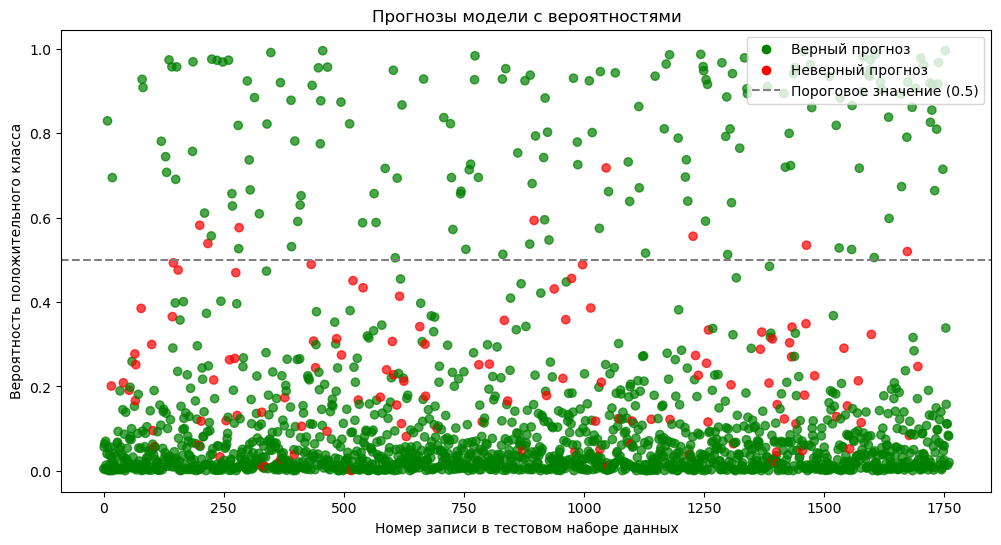

In [59]:
# Создаем массив индексов для удобства построения графика
indices = range(len(y_test))

# Определяем цвет точки: зеленый - правильный прогноз, красный - неправильный
colors = ['green' if true_label == (pred_proba >= 0.5) else 'red'
          for true_label, pred_proba in zip(y_test, y_pred_proba)]

# Создаем график
plt.figure(figsize=(12, 6))
scatter_predictions = plt.scatter(indices, y_pred_proba, c=colors, alpha=0.7, label='Прогнозы модели')

# Добавляем горизонтальную линию, соответствующую пороговому значению 0.5
threshold_line = plt.axhline(y=0.5, color='gray', linestyle='--', label='Пороговое значение (0.5)')

# Добавлем в легенду описание зеленых и красных точек
correct_prediction = plt.scatter([], [], color='green', label='Верный прогноз')
incorrect_prediction = plt.scatter([], [], color='red', label='Неверный прогноз')

# Добавляем заголовок и подписи осей
plt.title('Прогнозы модели с вероятностями')
plt.xlabel('Номер записи в тестовом наборе данных')
plt.ylabel('Вероятность положительного класса')

# Добавляем легенду
plt.legend(handles=[correct_prediction, incorrect_prediction, threshold_line], loc='upper right')

# Показываем график
plt.show()


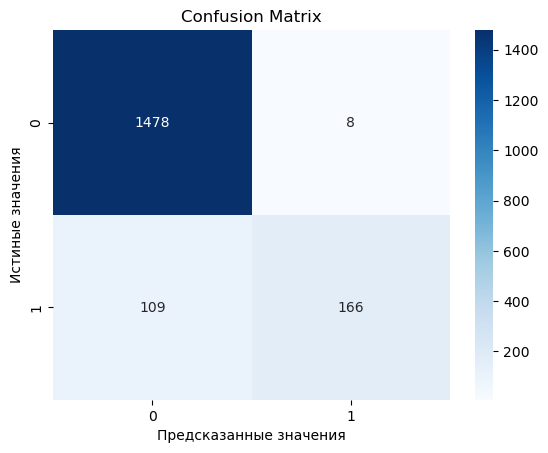

In [60]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истиные значения')
plt.show()

- Модель корректно предсказала 1478 клиентов, которые остались (класс 0). Это указывает на то, что модель хорошо определяет клиентов, которые не склонны к уходу. Высокое значение этой метрики свидетельствует о том, что можно с высокой точностью выделять стабильную клиентскую базу.  
- Всего 8 случаев, когда модель ошибочно предсказала уход для тех, кто на самом деле остался. В бизнесе это может привести к тому, что ресурсы будут тратиться на удержание клиентов, которые и так не планировали уходить.
- В 109 случаях модель не смогла определить уходящих клиентов. Это означает, что определенная доля клиентов скланных к уходу останется не выявленной.  
- Модель корректно выявила 166 уходящих клиентов. Это позволяет предпринять своевременные меры по удержанию таких клиентов.

В целом предсказания модели можно использовать как ЦА для маркетинговых акций.

Лучший результат, возможно, можно получить используя больший объем данных, или имея дополнительные признаки.

В реальности думаю сильно лучше результат получить не удастся, т.к. клиенты уходят по разным причинам, в т.ч. никак не связанным с ценой/качеством услуг.

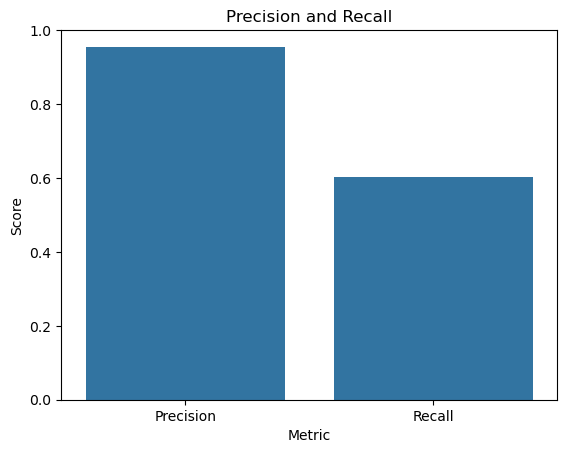

In [61]:
# Вычисление точности и полноты
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Отображение точности и полноты на графике
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall'],
    'Score': [precision, recall]
})

sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Precision and Recall')
plt.ylim(0, 1)
plt.show()

In [62]:
# Создаем диапазон пороговых значений
thresholds = np.linspace(0, 1, 100)

# Списки для хранения FN, FP и их суммы
fns = []
fps = []
sum_errors = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fns.append(fn)
    fps.append(fp)
    sum_errors.append(fn + fp)

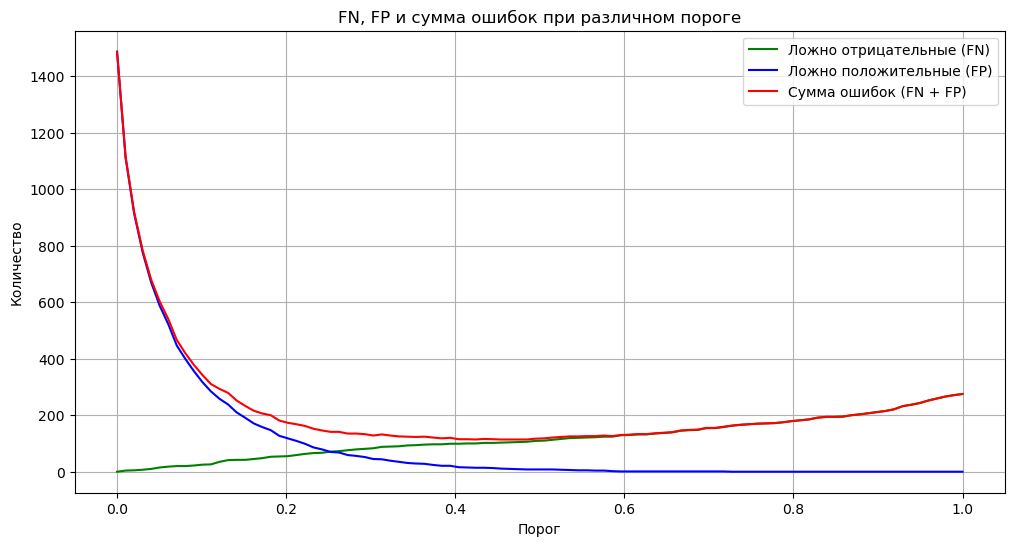

In [63]:
# Построение графика зависимости FN и FP от порога в одном графике
plt.figure(figsize=(12, 6))
plt.plot(thresholds, fns, label='Ложно отрицательные (FN)', color='green')
plt.plot(thresholds, fps, label='Ложно положительные (FP)', color='blue')
plt.plot(thresholds, sum_errors, label='Сумма ошибок (FN + FP)', color='red')
plt.xlabel('Порог')
plt.ylabel('Количество')
plt.title('FN, FP и сумма ошибок при различном пороге')
plt.legend()
plt.grid(True)
plt.show()

График демонстрирует, как выбор порогового значения влияет на точность нашей модели прогнозирования:
- Уменьшение порога позволяет лучше выявлять клиентов, которые собираются уйти - количество ошибок FN (зеленый график) уменьшается.  
При этом растет количество клиентов для которых модель выдаст ложное срабатывание - количество ошибок FP (синий график) растет. 

Необходимо оценить относительную стоимость FN и FP для бизнеса. Сколько стоит пропустить потенциального клиента по сравнению с проведением маркетинговой кампании для не заинтересованного человека?  
После этого можно будет расчитать оптимальный порог.


### Анализ важности признаков

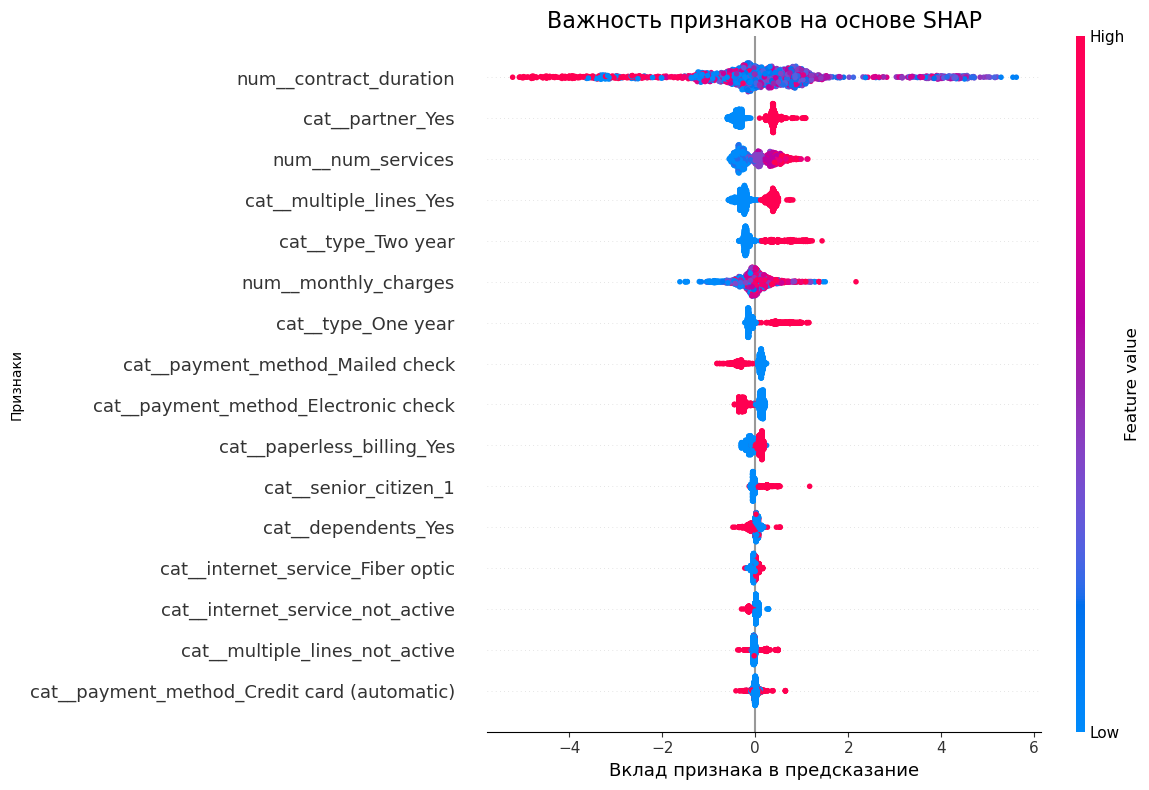

In [64]:
# Создаем SHAP Explainer для CatBoostClassifier
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

# Получаем преобразованные данные для обучения
#X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_test_processed)


# Визуализация SHAP с кастомизацией
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(), 
                  show=False, plot_size=[12,8])
plt.title('Важность признаков на основе SHAP', fontsize=16)
plt.xlabel('Вклад признака в предсказание')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

Если точки находятся с левой стороны графика, это говорит о том что признак характеризует лояльного клиента. Если с правой - склонного к уходу.  
Чем больше отклонение от оси - тем сильнее влияние.  
Красные точки - большее значение признака, или наличие этого признака для категориальных значений. Синие - наоборот.

По анализу важности признаков можно сделать следующие выводы:
- абоненты которые давно являются клиентами менее склонны к уходу
- женатые абоненты более склонны к уходу
- абоненты с помесячным типом контракта менее склонны к уходу
- чем ниже месячная плата, тем менее склонны к уходу клиенты
- абоненты с двухгодовым типом договра более склонны к уходу
- абоненты с несколькими телефонными линиями менее склонны к уходу (вероятно это юрлица?)

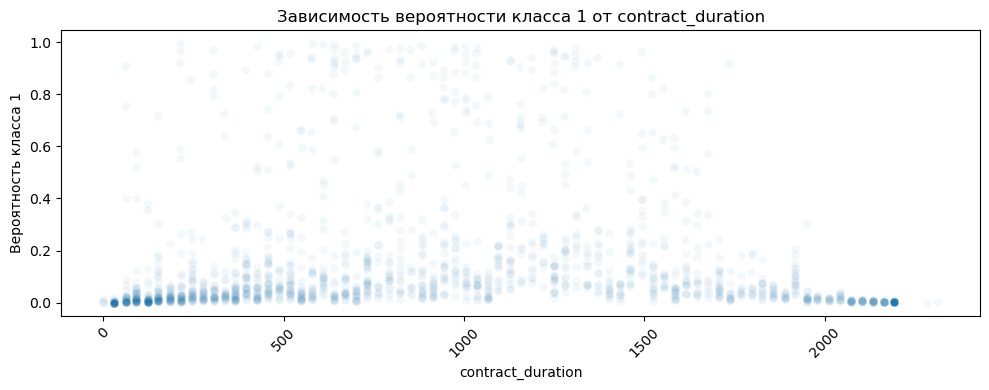

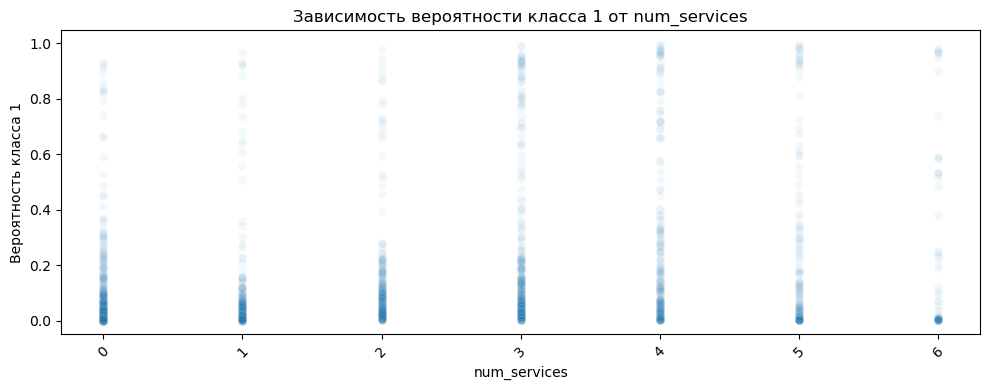

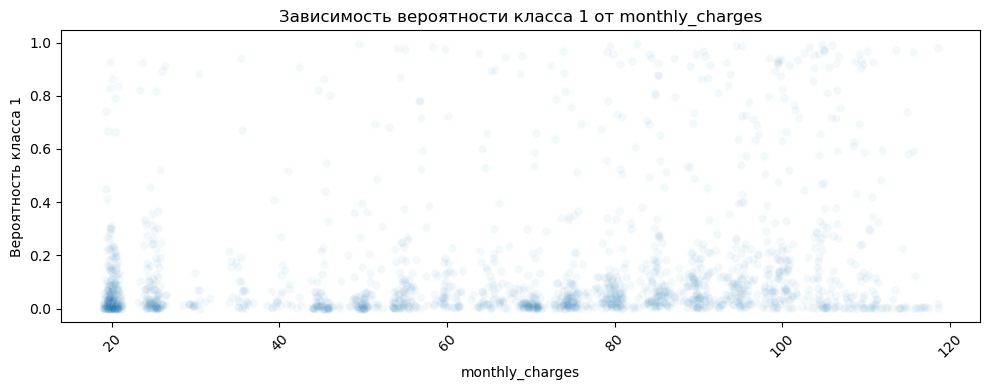

In [65]:
# Строим графики
for feature in ['contract_duration', 'num_services', 'monthly_charges']:
    plt.figure(figsize=(10, 4))
    sns.scatterplot(x=X_test[feature], y=y_pred_proba, alpha = 0.05)
    
    plt.title(f'Зависимость вероятности класса 1 от {feature}')
    plt.xlabel(feature)
    plt.ylabel('Вероятность класса 1')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Вывод

В принципе модель повторяет выводы, сделанные в ходе EDA. Заметен отток клиентов с большими месячными платежами и сроком "жизни" договора в диапазоне 700-1700 дней.  
Скопления точек (более тёмные пятна) в районе 700, 1400 дней, веротяно, объясняются тем, что заканчиваются двухгодовые контракты и люди их не продлевают.

### Общий вывод

Для меня самым важным фактором в оттоке клиентов кажется общая стоимость услуг  
(срок жизни договора - это следствие, а не причина. ни один человек не уйдет при идеальном качестве услуг и нулевой цене, как и не скажет при расторжении довора что "день пришел").  

Об этом так же свидетельствует: 
- отток клиентов с бОльшим количеством подключенных услуг (причина высоких платежей)
- доля расторжения договоров у абонентов с подключенными (любым количеством) услугами выше

Рекомендации для бизнеса:
- в целом динамика по количеству абонентов положительная, важно поддерживать качество предоставляемых услуг с учетом растущей нагрузки. Учитывать этот факт планировании модернизации материально=технической базы и объема людских ресурсов. (либо автоматизировать часть процессов)
- рассмотреть введение скидок для тех кто пользуется большим количеством платных услуг
- рассмотреть скидки для семейных людей и пенсионеров (хотя для пенсионеров причиной расторжения договоров может быть болезнь/смерть и т.п.)
- абоненты достаточно активны и пользуются дополнительными услугами (88% поключают доп услуги), есть смысл подумать над предложением более широкого спектра услуг
